# <span style='font-family:"Times New Roman"'> <span styel=''>**CANCER SPECIFIC ANALYSIS**
*Emile Cohen*
    
 *April 2020*

**Goal:** In this notebook, we want to explore all the metrics for one specific cancer. The cancer_type will be a parameter of this notebook.

The notebook is composed of 3 parts:
   * **General Information**
   * **Genomic Information**
   * **Clinical Information**
---

In [11]:
%run -i '../../../utils/setup_environment.ipy'

import warnings
warnings.filterwarnings('ignore')
from cancer_utils import *
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests

data_path = '../../../data/'

Setup environment... done!


<span style="color:green">✅ Working on **mskimpact_env** conda environment.</span>

In [381]:
cancer_type = 'Glioma'
mc = list(islice(cycle(list(sns.color_palette("muted"))), None, 6))
palette ={'>=1_LOSS':mc[0], 'HOMDEL':mc[1], '1_WILD_TYPE':mc[2], '>1muts':mc[3], '>=1_cnLOH':mc[4], '0_HETLOSS':mc[5]}
palette_list = [mc[5],mc[2],mc[3],mc[4],mc[0],mc[1]]
group_list = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '>=1_LOSS','HOMDEL']
master = load_clean_up_master(data_path + 'merged_data/master_file.pkl')
master_cancer = master[master['Cancer_Type'] == cancer_type]

In [3]:
set(master.Cancer_Type)

{'Adenocarcinoma In Situ',
 'Adrenocortical Carcinoma',
 'Ampullary Cancer',
 'Anal Cancer',
 'Appendiceal Cancer',
 'B-Lymphoblastic Leukemia/Lymphoma',
 'Bladder Cancer',
 'Blood Cancer, NOS',
 'Bone Cancer',
 'Breast Cancer',
 'Breast Sarcoma',
 'CNS Cancer',
 'Cancer of Unknown Primary',
 'Cervical Cancer',
 'Choroid Plexus Tumor',
 'Colorectal Cancer',
 'Embryonal Tumor',
 'Endometrial Cancer',
 'Esophagogastric Cancer',
 'Gastrointestinal Neuroendocrine Tumor',
 'Gastrointestinal Neuroendocrine Tumors of the Esophagus/Stomach',
 'Gastrointestinal Stromal Tumor',
 'Germ Cell Tumor',
 'Gestational Trophoblastic Disease',
 'Glioma',
 'Head and Neck Cancer',
 'Hepatobiliary Cancer',
 'Histiocytosis',
 'Lacrimal Gland Tumor',
 'Mature B-Cell Neoplasms',
 'Mature T and NK Neoplasms',
 'Melanoma',
 'Mesothelioma',
 'Miscellaneous Brain Tumor',
 'Miscellaneous Neuroepithelial Tumor',
 'Myelodysplastic Syndromes',
 'Nerve Sheath Tumor',
 'Non-Small Cell Lung Cancer',
 'Ovarian Cancer',
 '

# General

In [4]:
print_md('**' + cancer_type + '**')
print_md('* Number of samples: {}'.format(len(master_cancer)))
print_md('* Proportion in the entire cohort: {} %'.format(round(100*float(len(master_cancer))/float(len(master)),2)))

**Glioma**

* Number of samples: 1540

* Proportion in the entire cohort: 5.6 %

In [8]:
print(master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] == 'DIPLOID'].shape[0])
print(master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0])
print(master_cancer[master_cancer['tp53_count'] ==0][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0])

150
362
203


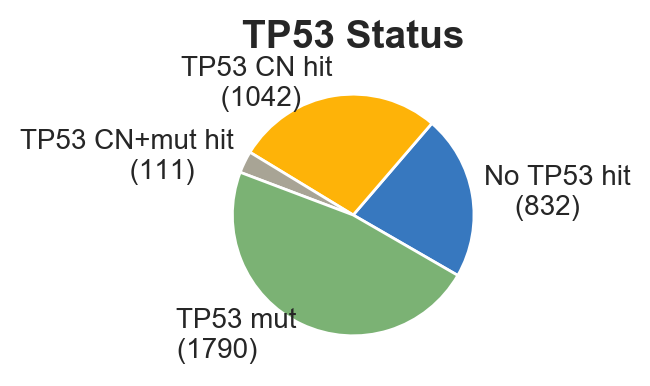

In [250]:
fig = plt.figure(figsize=(4,2))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)

sizes = [master_cancer.shape[0] - master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] == 'DIPLOID'].shape[0] - master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0] - master_cancer[master_cancer['tp53_count'] ==0][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0], 
        master_cancer[master_cancer['tp53_count'] ==0][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0],
        master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] == 'DIPLOID'].shape[0],
        master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0]  
        ]

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]

labels = ['No TP53 hit\n    (' + str(sizes[0])+')', 'TP53 CN hit\n     ('+str(sizes[1])+')    ', 'TP53 CN+mut hit\n     ('+str(sizes[2])+')     ',  '    TP53 mut\n        ('+str(sizes[3])+')     ']
patches, texts = ax.pie(sizes, labels=labels, startangle=330, colors=sns.xkcd_palette(colors))
texts = [ _.set_fontsize(10) for _ in texts ]
ax.set_title('TP53 Status', weight='bold', fontsize=14)
plt.show()
plt.show(fig)

In [53]:
master_cancer[master_cancer['tp53_count'] >=1].shape[0]

512

## Sample Type proportion

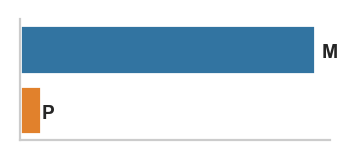

In [78]:
sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(2,0.8))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
g = sns.countplot(data=master_cancer, y='Sample_Type', ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
g.set(xticklabels=[])
g.set(yticklabels=[])

rects = ax.patches
labels = ['M', 'P']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    width = rect.get_width()
    ax.text(width*(102/100) , rect.get_y()+(3/4)*height,  str(label),
        ha='left', va='bottom', weight='bold', fontsize=7) 


count_Sample_Type
Sample_Type                   
Metastasis                 761
Primary                    290

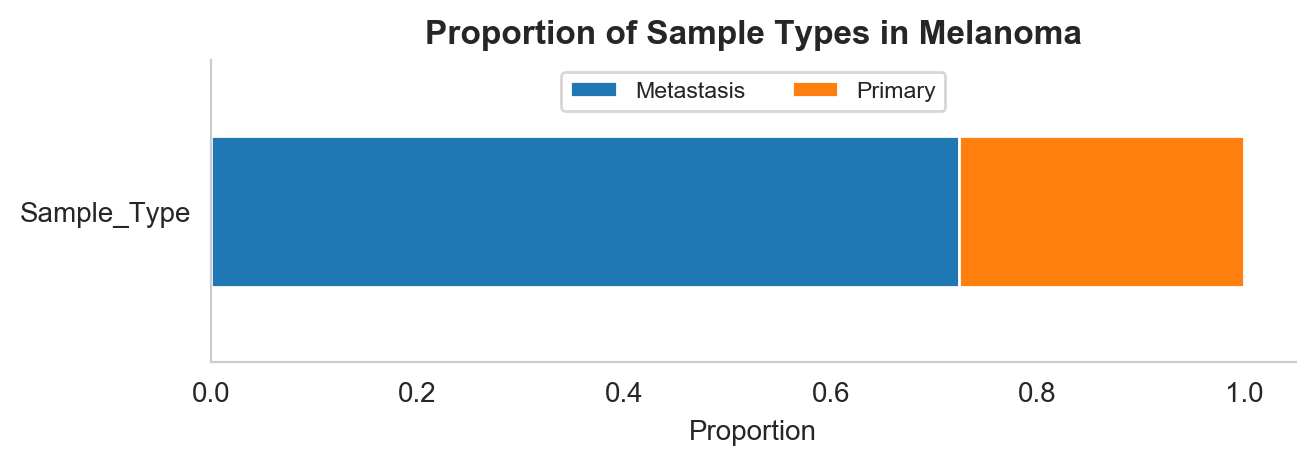

In [243]:
fig, ax = proportion_plot(master_cancer, 
                metrics='Sample_Type',
                title= 'Proportion of Sample Types in ' + cancer_type,
                figsize=(7,2),
                display_table=True, 
                ncol_legend =2)

## TP53 Mutants

**Melanoma**

* Number of TP53 muted samples: 183 

* Proportion of TP53 muted samples: 17.26 %

count_tp53_count
tp53_count                  
0                        877
1                        160
2                         19
3                          4

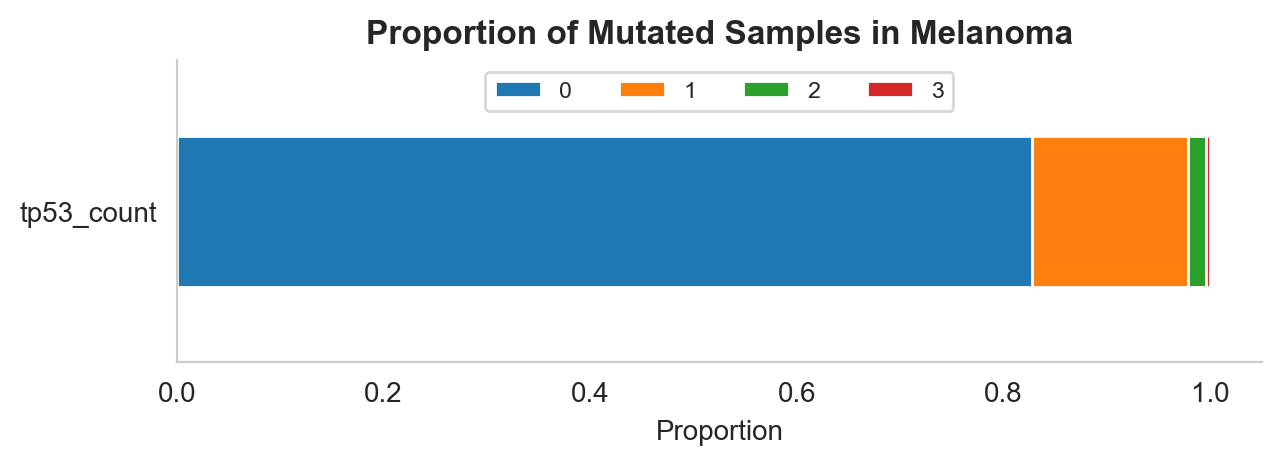

In [244]:
print_md('**' + cancer_type + '**')
print_md('* Number of TP53 muted samples: {} '.format(len(master_cancer[master_cancer['tp53_count']>=1])))
print_md('* Proportion of TP53 muted samples: {} %'.format(round(100*float(len(master_cancer[master_cancer['tp53_count']>=1]))/float(len(master_cancer)),2)))

fig, ax = proportion_plot(master_cancer, 
                metrics='tp53_count',
                title= 'Proportion of Mutated Samples in ' + cancer_type,
                figsize=(7,2),
                display_table=True, 
                ncol_legend =6)

prim_count  met_count     sum
tp53_count                               
0                 1219      640.0  1859.0
1                  946      809.0  1755.0
2                   87       49.0   136.0
3                    6        3.0     9.0
4                    1        NaN     NaN

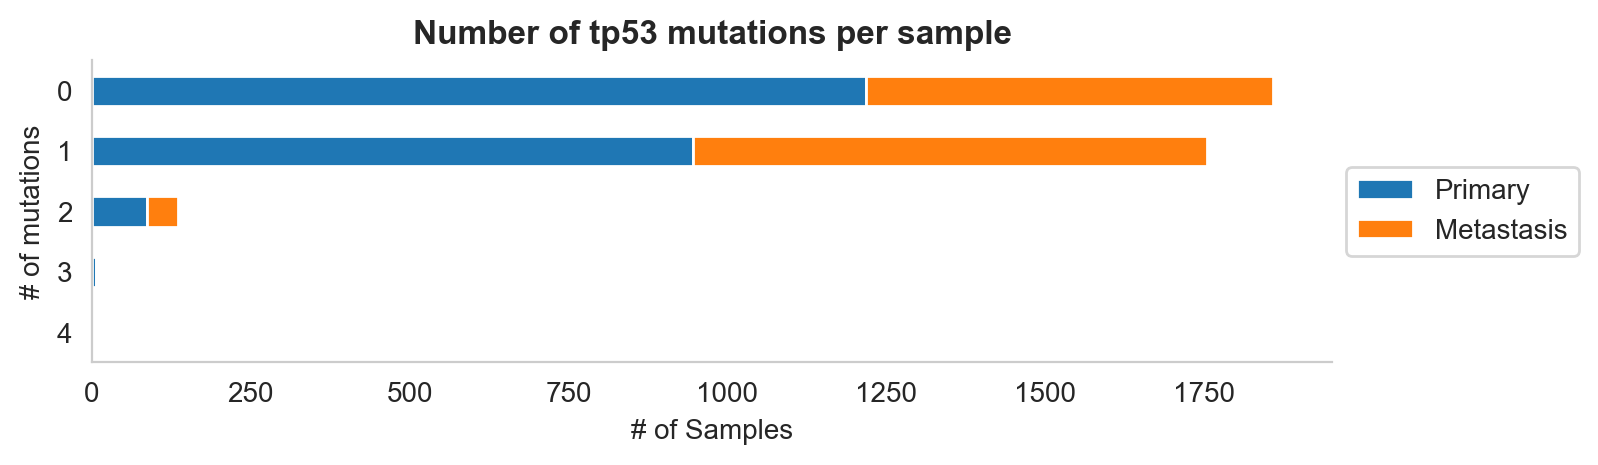

In [33]:
master_tp53 = master_cancer[master_cancer['tp53_count'] >= 0]
# We filter out the duplicates and keep only the Primary Samples
master_tp53_prim = master_tp53[master_tp53['Sample_Type'] == 'Primary']
master_tp53_met = master_tp53[master_tp53['Sample_Type'] == 'Metastasis']

# Counting
count_0hetloss = get_groupby(master_tp53_prim, 'tp53_count', 'prim_count')
count_met = get_groupby(master_tp53_met, 'tp53_count', 'met_count')

#We rename the column
count = pd.concat([count_prim, count_met],
                  axis=1).sort_values(by=['prim_count'])
count['sum'] = count.apply(lambda x: x.prim_count + x.met_count, axis=1)
count_ = count.sort_values(by='sum', ascending=False)
len(master_cancer)
print()
display(count_)

ax, fig = get_mstacked_plot(count[['prim_count', 'met_count']],
                            'Number of tp53 mutations per sample',
                            ['Primary', 'Metastasis'],
                            '# of Samples',
                            '# of mutations',
                            figsize=(10, 2))

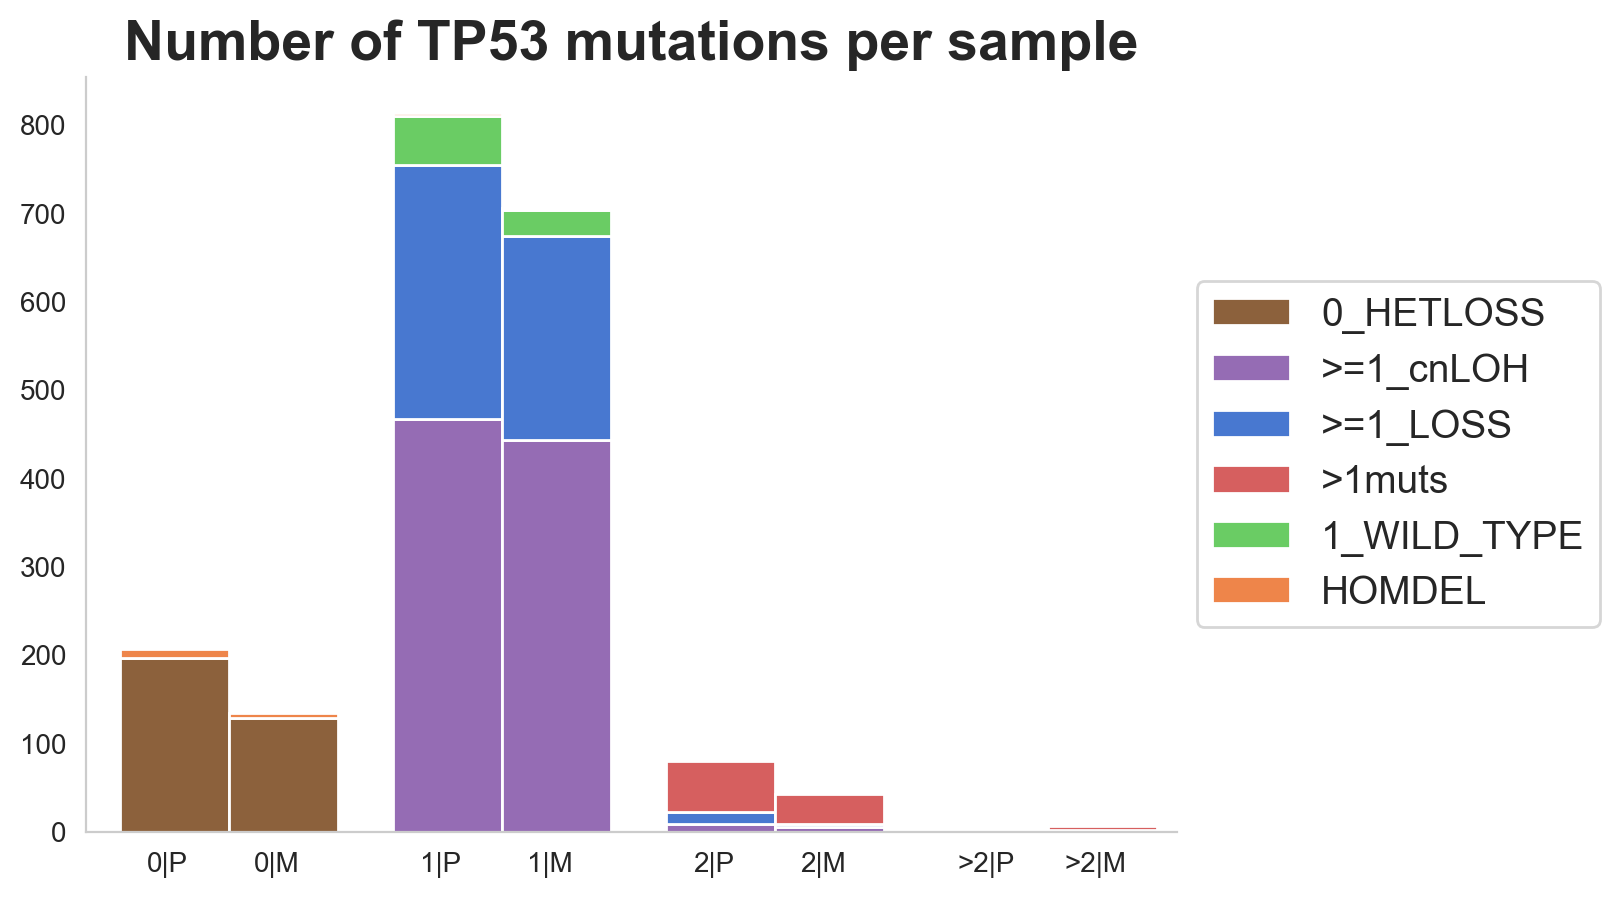

In [302]:
groups = ['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL']

for i,group in enumerate(groups):
    master_group = master_cancer[master_cancer['tp53_group'] == group]#[master_cancer['tp53_count']<4]
    groupby_prim = get_groupby(master_group[master_group['Sample_Type'] == 'Primary'], 'tp53_count', group + '_count')
    groupby_met = get_groupby(master_group[master_group['Sample_Type'] == 'Metastasis'], 'tp53_count', group + '_count')
    if i == 0 : met = groupby_met ; prim = groupby_prim
    else: met = pd.concat([met, groupby_met], axis=1) ; prim = pd.concat([prim, groupby_prim], axis=1)
for i in [0,1,2,3,4,5]:
    if i not in met.index: met.loc[i]=[0]*6
    if i not in prim.index: prim.loc[i]=[0]*6   
met = met.fillna(0) ; prim = prim.fillna(0)
met.index = ['0 | M', '1 | M', '2 | M', '3 | M', '4 | M', '5 | M'] ; prim.index = ['0 | P', '1 | P', '2 | P', '3 | P', '4 | P', '5 | P']
count = pd.concat([met, prim], axis=0)
#count['sum'] = count.sum(axis=1)
count= count.fillna(0)
count = count.reindex(['0 | P', '0 | M','1 | P','1 | M','2 | P','2 | M','3 | P','3 | M', '4 | P', '4 | M', '5 | P', '5 | M'])
count.loc['>2 | M'] = count.apply(lambda x: x['3 | M'] + x['4 | M'] + x['5 | M'], axis=0)
count.loc['>2 | P'] = count.apply(lambda x: x['3 | P'] + x['4 | P'] + x['5 | P'], axis=0)
count = count.drop(['3 | P','3 | M', '4 | P', '4 | M', '5 | P', '5 | M'])


fig = plt.figure(figsize=(11,5))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
h = count.plot(kind = 'bar', stacked=True, ax=ax)
h.set_xticklabels(['0|P', '0|M','1|P','1|M','2|P','2|M','>2|P','>2|M'], rotation=0)

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.set_title('Number of TP53 mutations per sample',weight='bold', fontsize=20)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid(True)

palette_list_new = [mc[5],mc[4],mc[0],mc[3],mc[2], mc[1]]
for j,container in enumerate(ax.containers):
    for i, child in enumerate(container.get_children()):
        child.set_facecolor(palette_list_new[j])
        if i%2 == 1: child.set_x(child.get_x() - 0.2)
        child.set_width(0.8)
        
ax.set_xticks([0.1, 0.9, 2.1, 2.9, 4.1, 4.9, 6.1, 6.9])

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax.legend(['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)



#h[1].set_facecolor('red')
plt.show()

## Subgroup proportion

In [ ]:
def proportion_plot(df:pd.DataFrame, metrics: str,title: str,  figsize=(7,2),display_table=False, tp53_metrics=False, ncol_legend:int =5):
    if tp53_metrics == True:
            data_1 =  pd.DataFrame(df[['Tumor_Id', metrics + '_1']])
            data_1.columns = ['Tumor_Id', metrics]
            data_2 = pd.DataFrame(df[['Tumor_Id', metrics + '_2']])
            data_2.columns = ['Tumor_Id', metrics]
            data_3 = pd.DataFrame(df[['Tumor_Id', metrics + '_3']])
            data_3.columns = ['Tumor_Id', metrics]
            data_4 = pd.DataFrame(df[['Tumor_Id', metrics + '_4']])
            data_4.columns = ['Tumor_Id', metrics]
            data_5 = pd.DataFrame(df[['Tumor_Id', metrics + '_5']])
            data_5.columns = ['Tumor_Id', metrics]
            data_tot = data_1.append(data_2)
            data_tot = data_tot.append(data_3)
            data_tot = data_tot.append(data_4)
            data_tot = data_tot.append(data_5)
    
            df = pd.merge(left=data_tot, right=df[['Tumor_Id','tp53_cn_state', 'tp53_tcn', 'Sample_Type']],how='left', left_on='Tumor_Id',right_on='Tumor_Id')

    count = get_groupby(df, metrics, 'count_' + metrics)
    freq = pd.DataFrame(count['count_' + metrics]).sort_values(by=['count_' + metrics], ascending=False)/ pd.DataFrame(count['count_' + metrics]).sum()
    freq.columns=['%']
    if display_table:
        display(count.sort_values(by = 'count_'+metrics, ascending=False))

    fig, ax = plt.subplots()
    freq.T.plot(kind = 'barh', stacked=True, figsize = figsize, ax=ax, yticks=[])
    plt.title(title, weight = 'bold')
    plt.legend(loc = 'upper center', fontsize='small', ncol=ncol_legend)
    ax.yaxis.set_major_formatter(matplotlib.ticker.IndexFormatter([metrics]))
    ax.set_xlabel('Proportion')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    return fig, ax

M         P
0_HETLOSS    0.068966  0.100223
1_WILD_TYPE  0.172414  0.133630
>1muts       0.241379  0.207127
>=1_cnLOH    0.379310  0.360802
>=1_LOSS     0.137931  0.173719
HOMDEL            NaN  0.024499

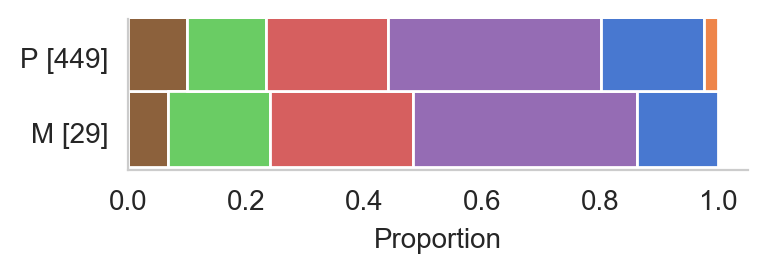

In [199]:
fig, ax = plt.subplots()
metrics='tp53_group'

count_prim = get_groupby(master_cancer[master_cancer['Sample_Type'] == 'Primary'], metrics, 'count_prim_' + metrics)
count_met = get_groupby(master_cancer[master_cancer['Sample_Type'] == 'Metastasis'], metrics, 'count_met_' + metrics)
freq_prim = pd.DataFrame(count_prim['count_prim_' + metrics]).sort_values(by=['count_prim_' + metrics], ascending=False)/ pd.DataFrame(count_prim['count_prim_' + metrics]).sum()
freq_met = pd.DataFrame(count_met['count_met_' + metrics]).sort_values(by=['count_met_' + metrics], ascending=False)/ pd.DataFrame(count_met['count_met_' + metrics]).sum()
freq_prim.columns=['P'] ; freq_met.columns=['M']
freq = pd.concat([freq_met, freq_prim], axis=1)
freq = freq.reindex(group_list)
display(freq)

freq.T.plot(kind = 'barh', stacked=True, figsize = (4,1), ax=ax, yticks=[], color=palette_list)
ax.set_title('', weight = 'bold', fontsize=12)
ax.legend_.remove()
ax.yaxis.set_major_formatter(matplotlib.ticker.IndexFormatter(['M ' + str(pd.DataFrame(count_met['count_met_' + metrics]).sum().values), 'P ' + str(pd.DataFrame(count_prim['count_prim_' + metrics]).sum().values)]))
ax.set_xlabel('Proportion')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

for container in ax.containers:
    for i, child in enumerate(container.get_children()):
        child.set_y(child.get_y() - 0.2)
        child.set_height(1)
        


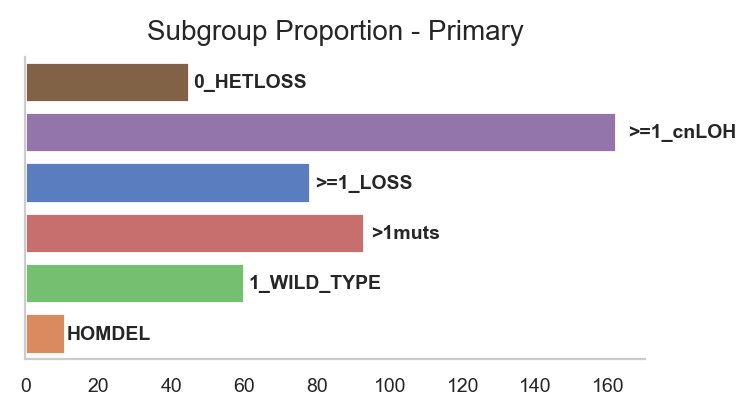

In [84]:
sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(4,2))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
ax.set_title('Subgroup Proportion - Primary', fontsize=10)
g = sns.countplot(data=master_cancer[master_cancer['Sample_Type']== 'Primary'],
                  y='tp53_group', ax=ax,
                  order = ['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL'],
                 palette=palette)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
#g.set(xticklabels=[])
g.set(yticklabels=[])
ax.xaxis.set_tick_params(labelsize=7)


rects = ax.patches
labels = ['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL']
for rect, label in zip(rects, labels):
    height = rect.get_height() 
    width = rect.get_width()
    if np.isnan(width) : width = 0
    ax.text(width*(102/100) , rect.get_y()+(3/4)*height,  str(label),
       ha='left', va='bottom', weight='bold', fontsize=7) 

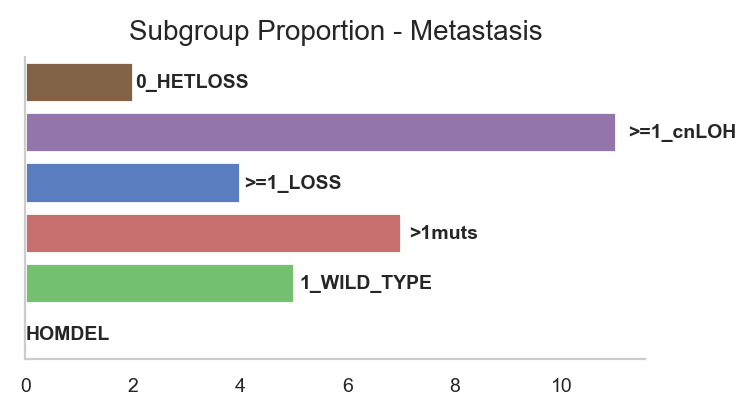

In [85]:
# Prim Samples
sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(4,2))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
ax.set_title('Subgroup Proportion - Metastasis', fontsize=10)
g = sns.countplot(data=master_cancer[master_cancer['Sample_Type']== 'Metastasis'],
                  order=['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL'],
                  y='tp53_group', ax=ax,
                 palette=palette)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
#g.set(xticklabels=[])
g.set(yticklabels=[])
ax.xaxis.set_tick_params(labelsize=7)

rects = ax.patches
labels = ['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL']
for rect, label in zip(rects, labels):
    height = rect.get_height()
    width = rect.get_width()
    width = rect.get_width()
    if np.isnan(width) : width = 0
    ax.text(width*(102/100) , rect.get_y()+(3/4)*height,  str(label),
        ha='left', va='bottom', weight='bold', fontsize=7) 

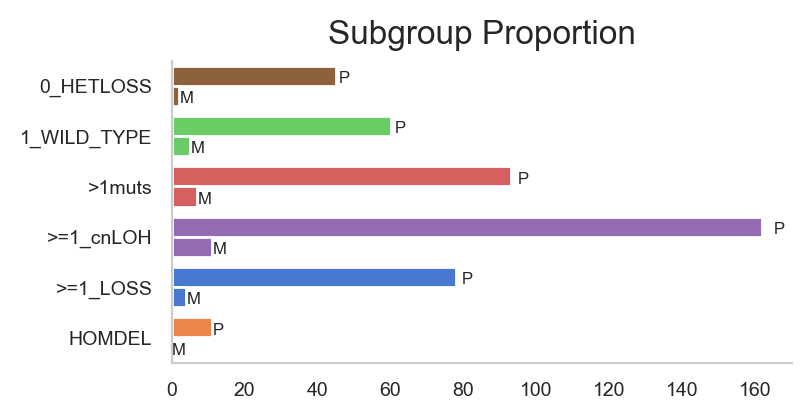

In [87]:
# Met Samples
sns.set_style("whitegrid", {'grid.color': '1.'})
fig = plt.figure(figsize=(4,2))
ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
ax.set_title('Subgroup Proportion', fontsize=12)
g = sns.countplot(data=master_cancer, y='tp53_group', ax=ax, hue='Sample_Type',
                  order=group_list)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_ylabel('')
ax.xaxis.set_tick_params(labelsize=7)
ax.yaxis.set_tick_params(labelsize=7)
ax.get_legend().remove()

rects = ax.patches
labels = group_list*2
met_prim = ['P']*6 + ['M']*6
for rect, label, i in zip(rects, labels, range(12)):
    height = rect.get_height()
    width = rect.get_width()
    width = rect.get_width()
    if np.isnan(width) : width = 0
    ax.text(width*(102/100) , rect.get_y()+height,  str(met_prim[i]),
        ha='left', va='bottom', fontsize=6)
    rect.set_facecolor(palette[label])


## Densities (Purity, VAF, CCF)

### Purity

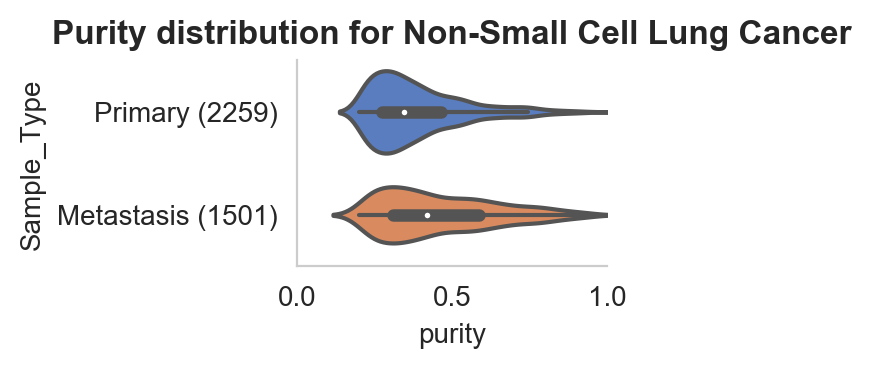

In [10]:
sns.set_style("whitegrid", {'grid.color': '1.'})
fig, ax = boxplot_sampletype(master_cancer,
                             'purity',
                             figsize= (2,3),
                             title='Purity distribution for ' + cancer_type, 
                             title_font=12,
                            continuous=True)

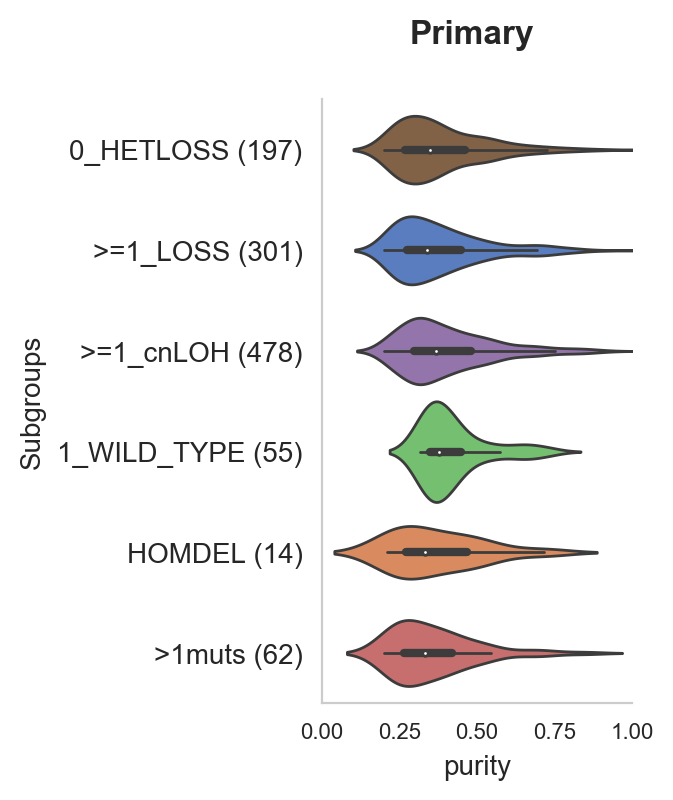

In [24]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='purity', 
                         title= 'Primary', 
                         figsize = (2, 4),  
                         xlim=1, 
                         met_prim = 'Primary',
                         continuous=True,
                         linewidth=1)

plt.show(fig)

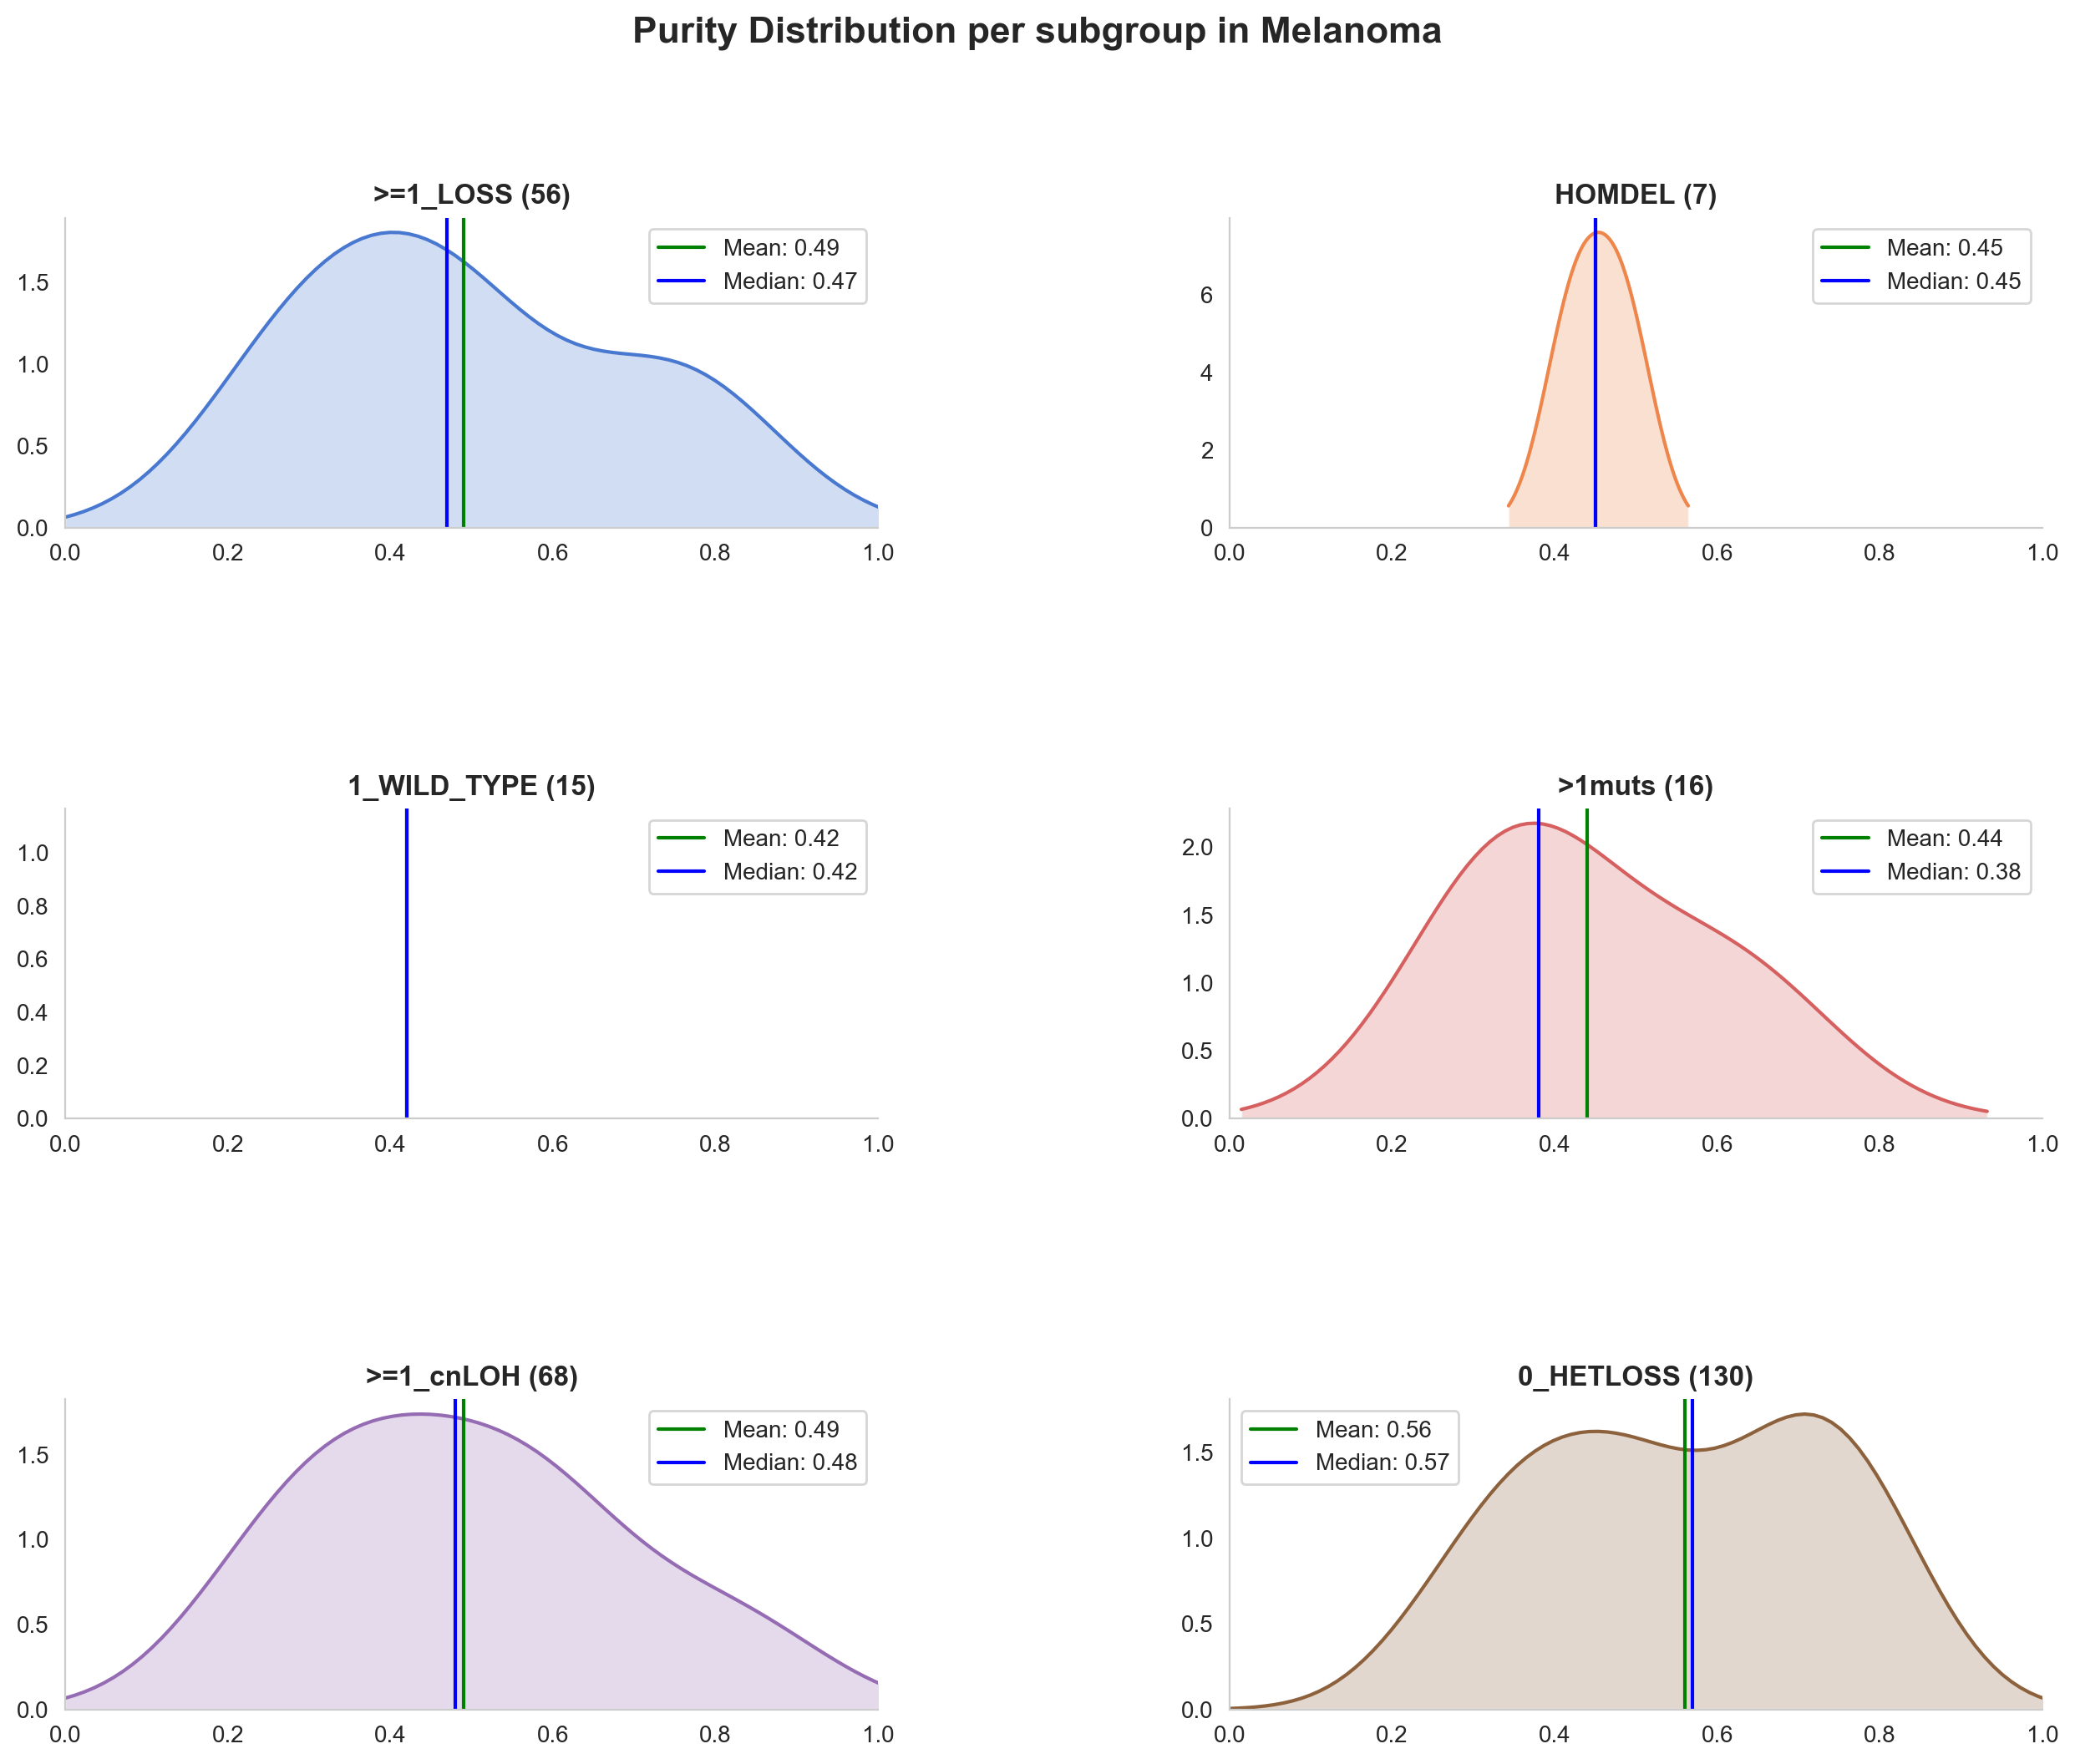

In [251]:
fig, ax = get_densities(master_cancer,
              metrics= 'purity', 
              fig_title= 'Purity Distribution per subgroup in ' + cancer_type, 
              xlabel='', 
              ylabel='',  
              number=6, 
              tp53_metrics=False,
              met_prim = 'Primary', 
              clip = (0.0,3.0), 
              x_lim =[0,1])

### TP53

#### VAF

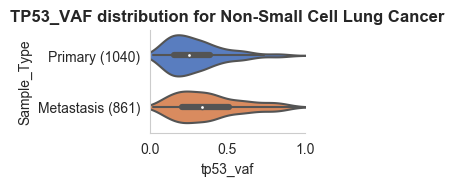

In [4]:
sns.set_style("whitegrid", {'grid.color': '1.'})
fig, ax = boxplot_sampletype(master_cancer,
                             'tp53_vaf', 
                             figsize= (2,3), 
                             title='TP53_VAF distribution for ' + cancer_type, 
                             tp53_metrics=True,
                             title_font=12,
                            continuous=True)

{'1_WILD_TYPE': 55, '>1muts': 62, '>=1_LOSS': 301, '>=1_cnLOH': 478, 'HOMDEL': 4}


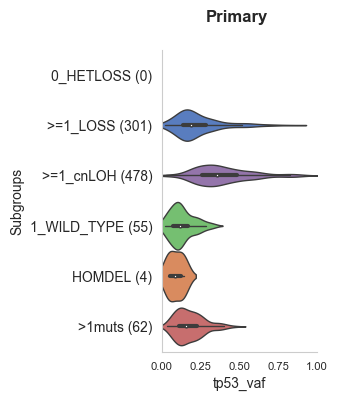

In [5]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='tp53_vaf', 
                         title= 'Primary', 
                         figsize = (2, 4),  
                         xlim=1, 
                         met_prim = 'Primary',
                         continuous=True,
                         tp53_metrics=True,
                         linewidth=1)

plt.show(fig)

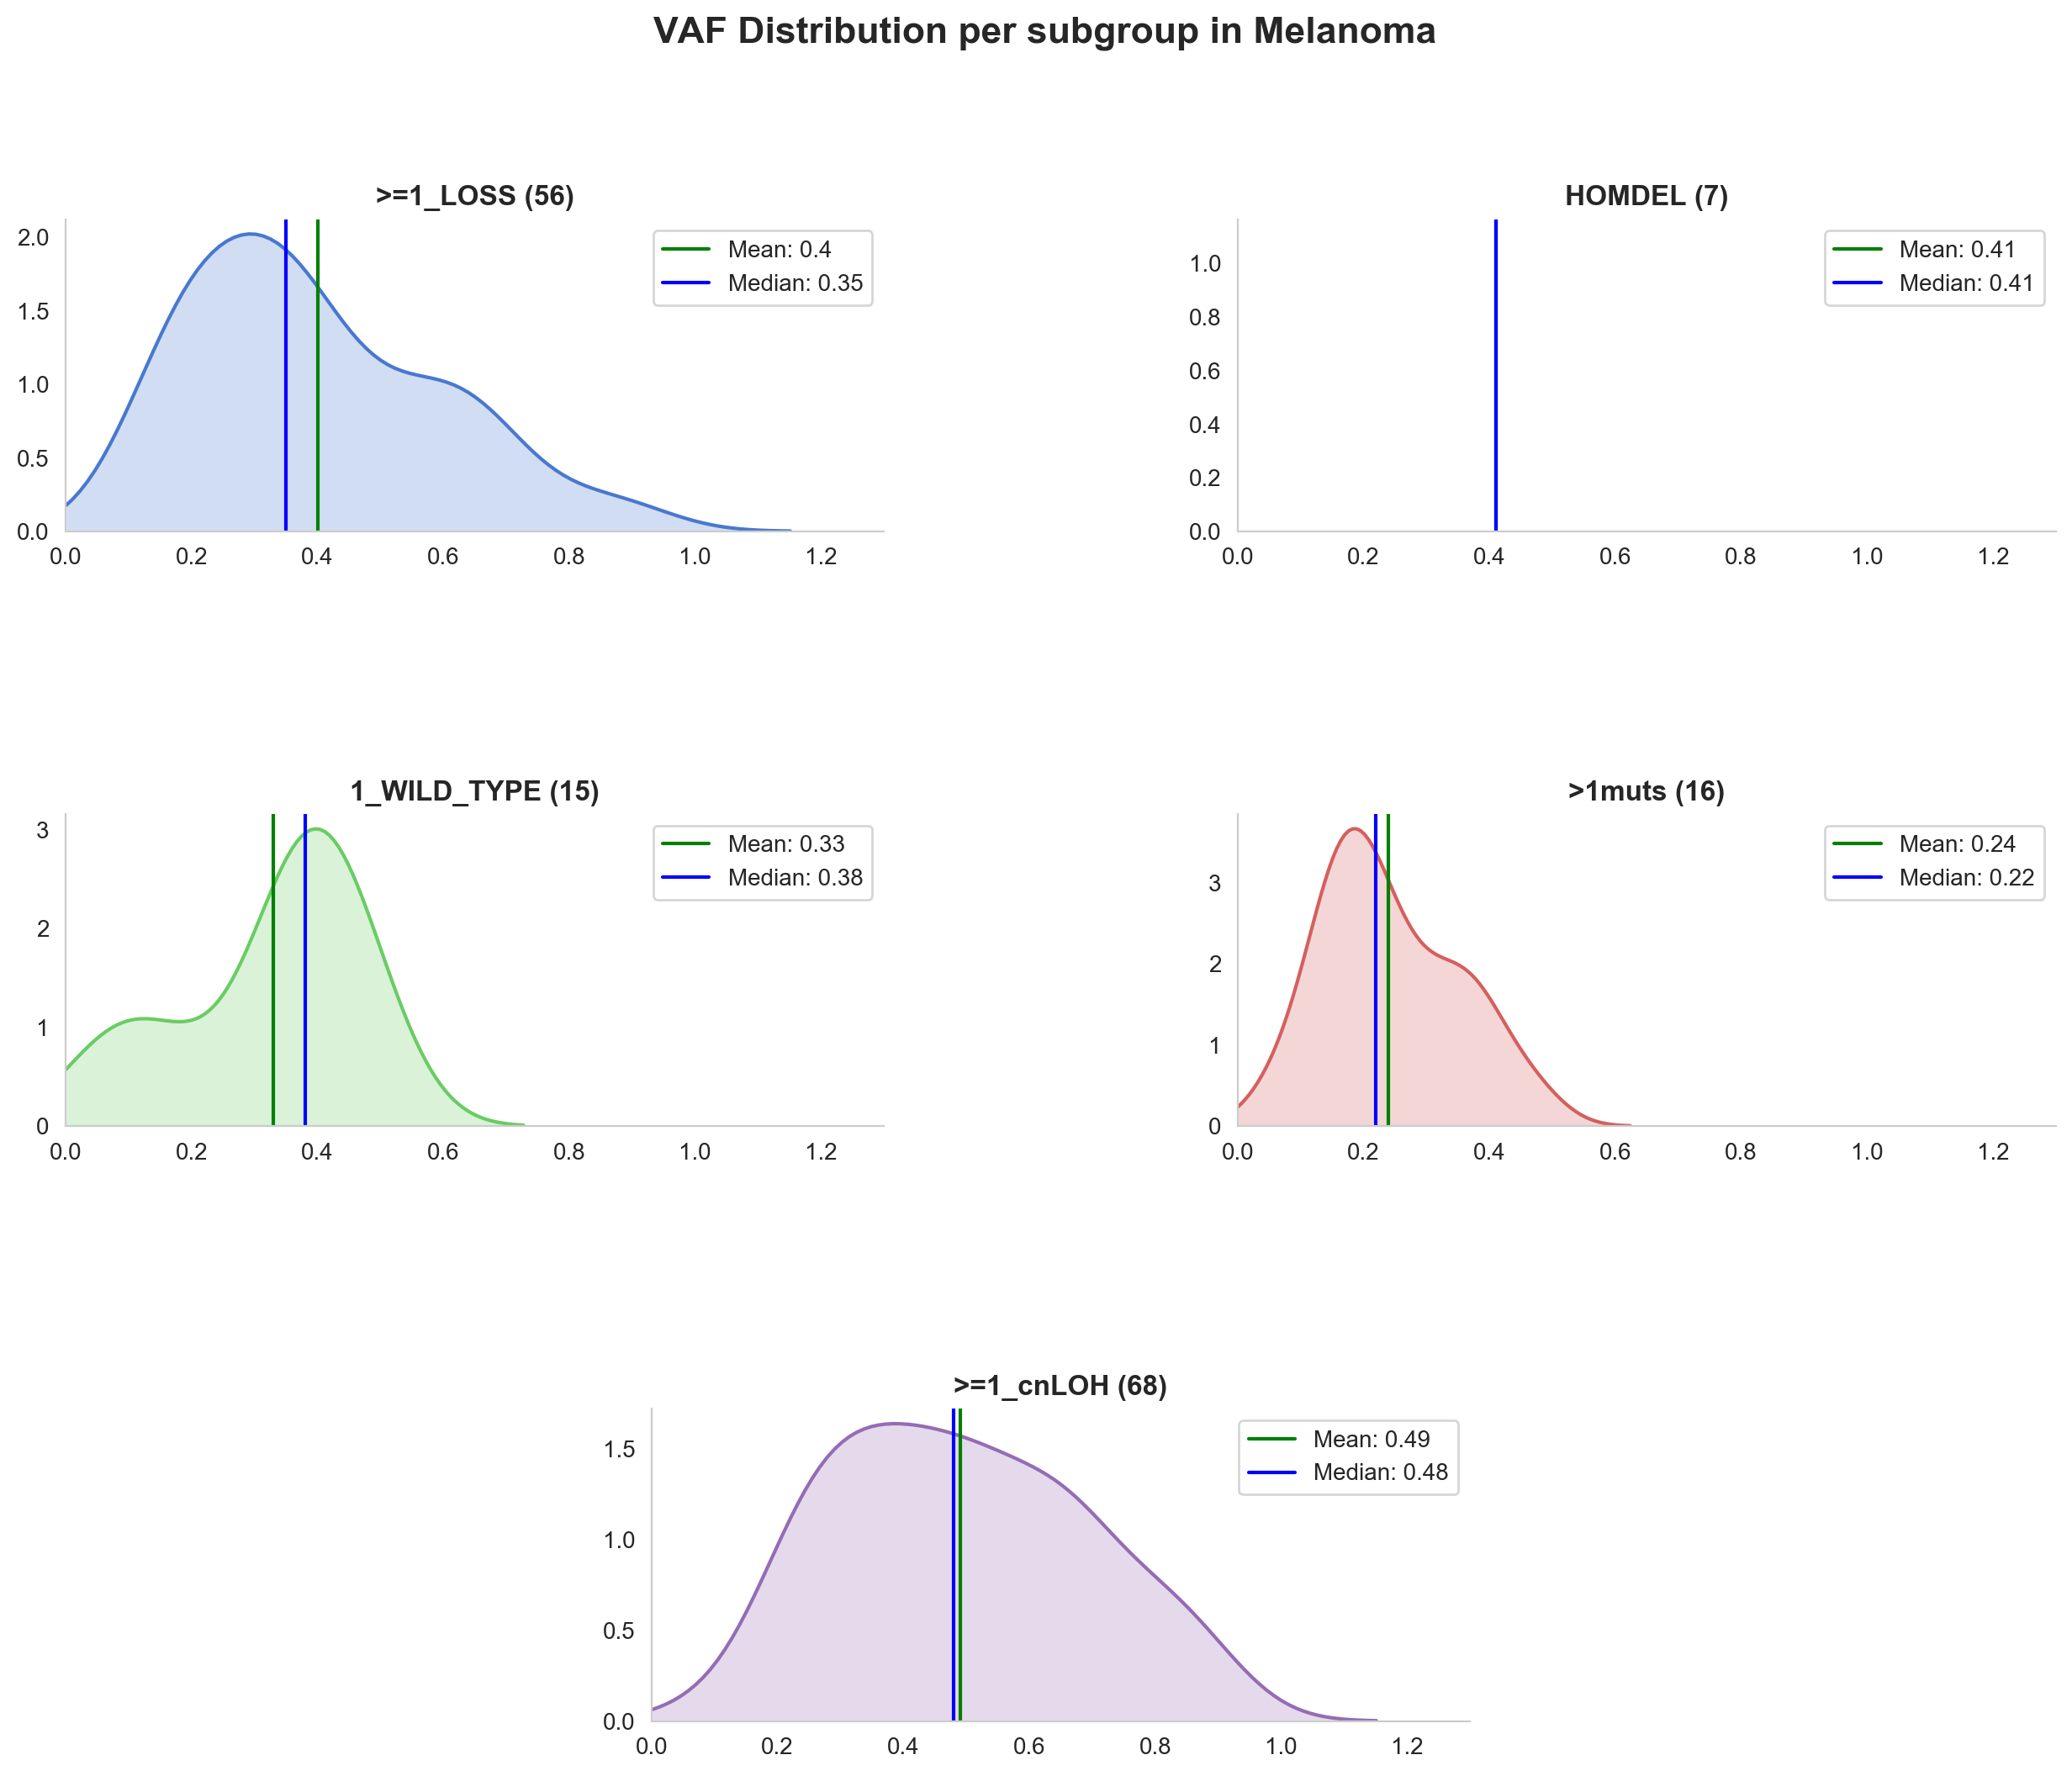

In [253]:
fig, ax = get_densities(master_cancer,
              metrics= 'tp53_vaf', 
              fig_title= 'VAF Distribution per subgroup in ' + cancer_type, 
              xlabel='', 
              ylabel='',  
              number=5, 
              tp53_metrics=True,
              met_prim = None, 
              clip = (0.0,3.0), 
              x_lim =[0,1.3])

### CCF

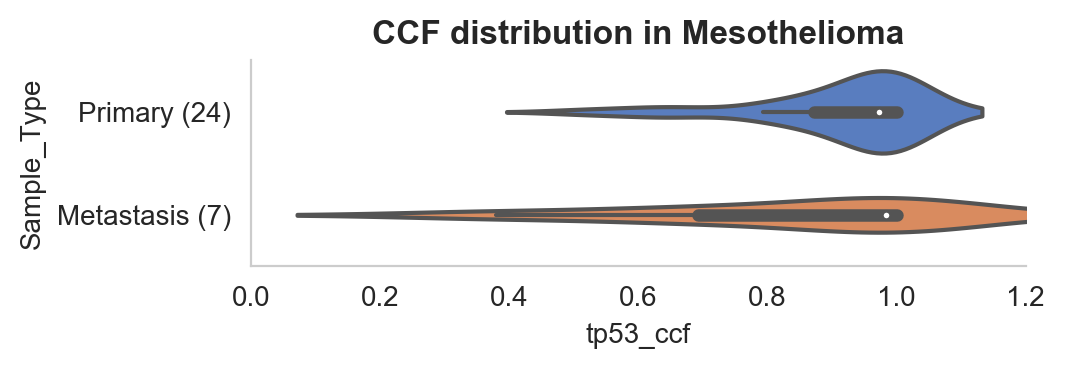

In [15]:
fig, ax = boxplot_sampletype(master_cancer, 
                             'tp53_ccf', 
                             figsize= (5,3), 
                             title='CCF distribution in ' + cancer_type, 
                             title_font=12,
                             tp53_metrics=True,
                             xlim=[0,1.2], 
                            continuous=True)

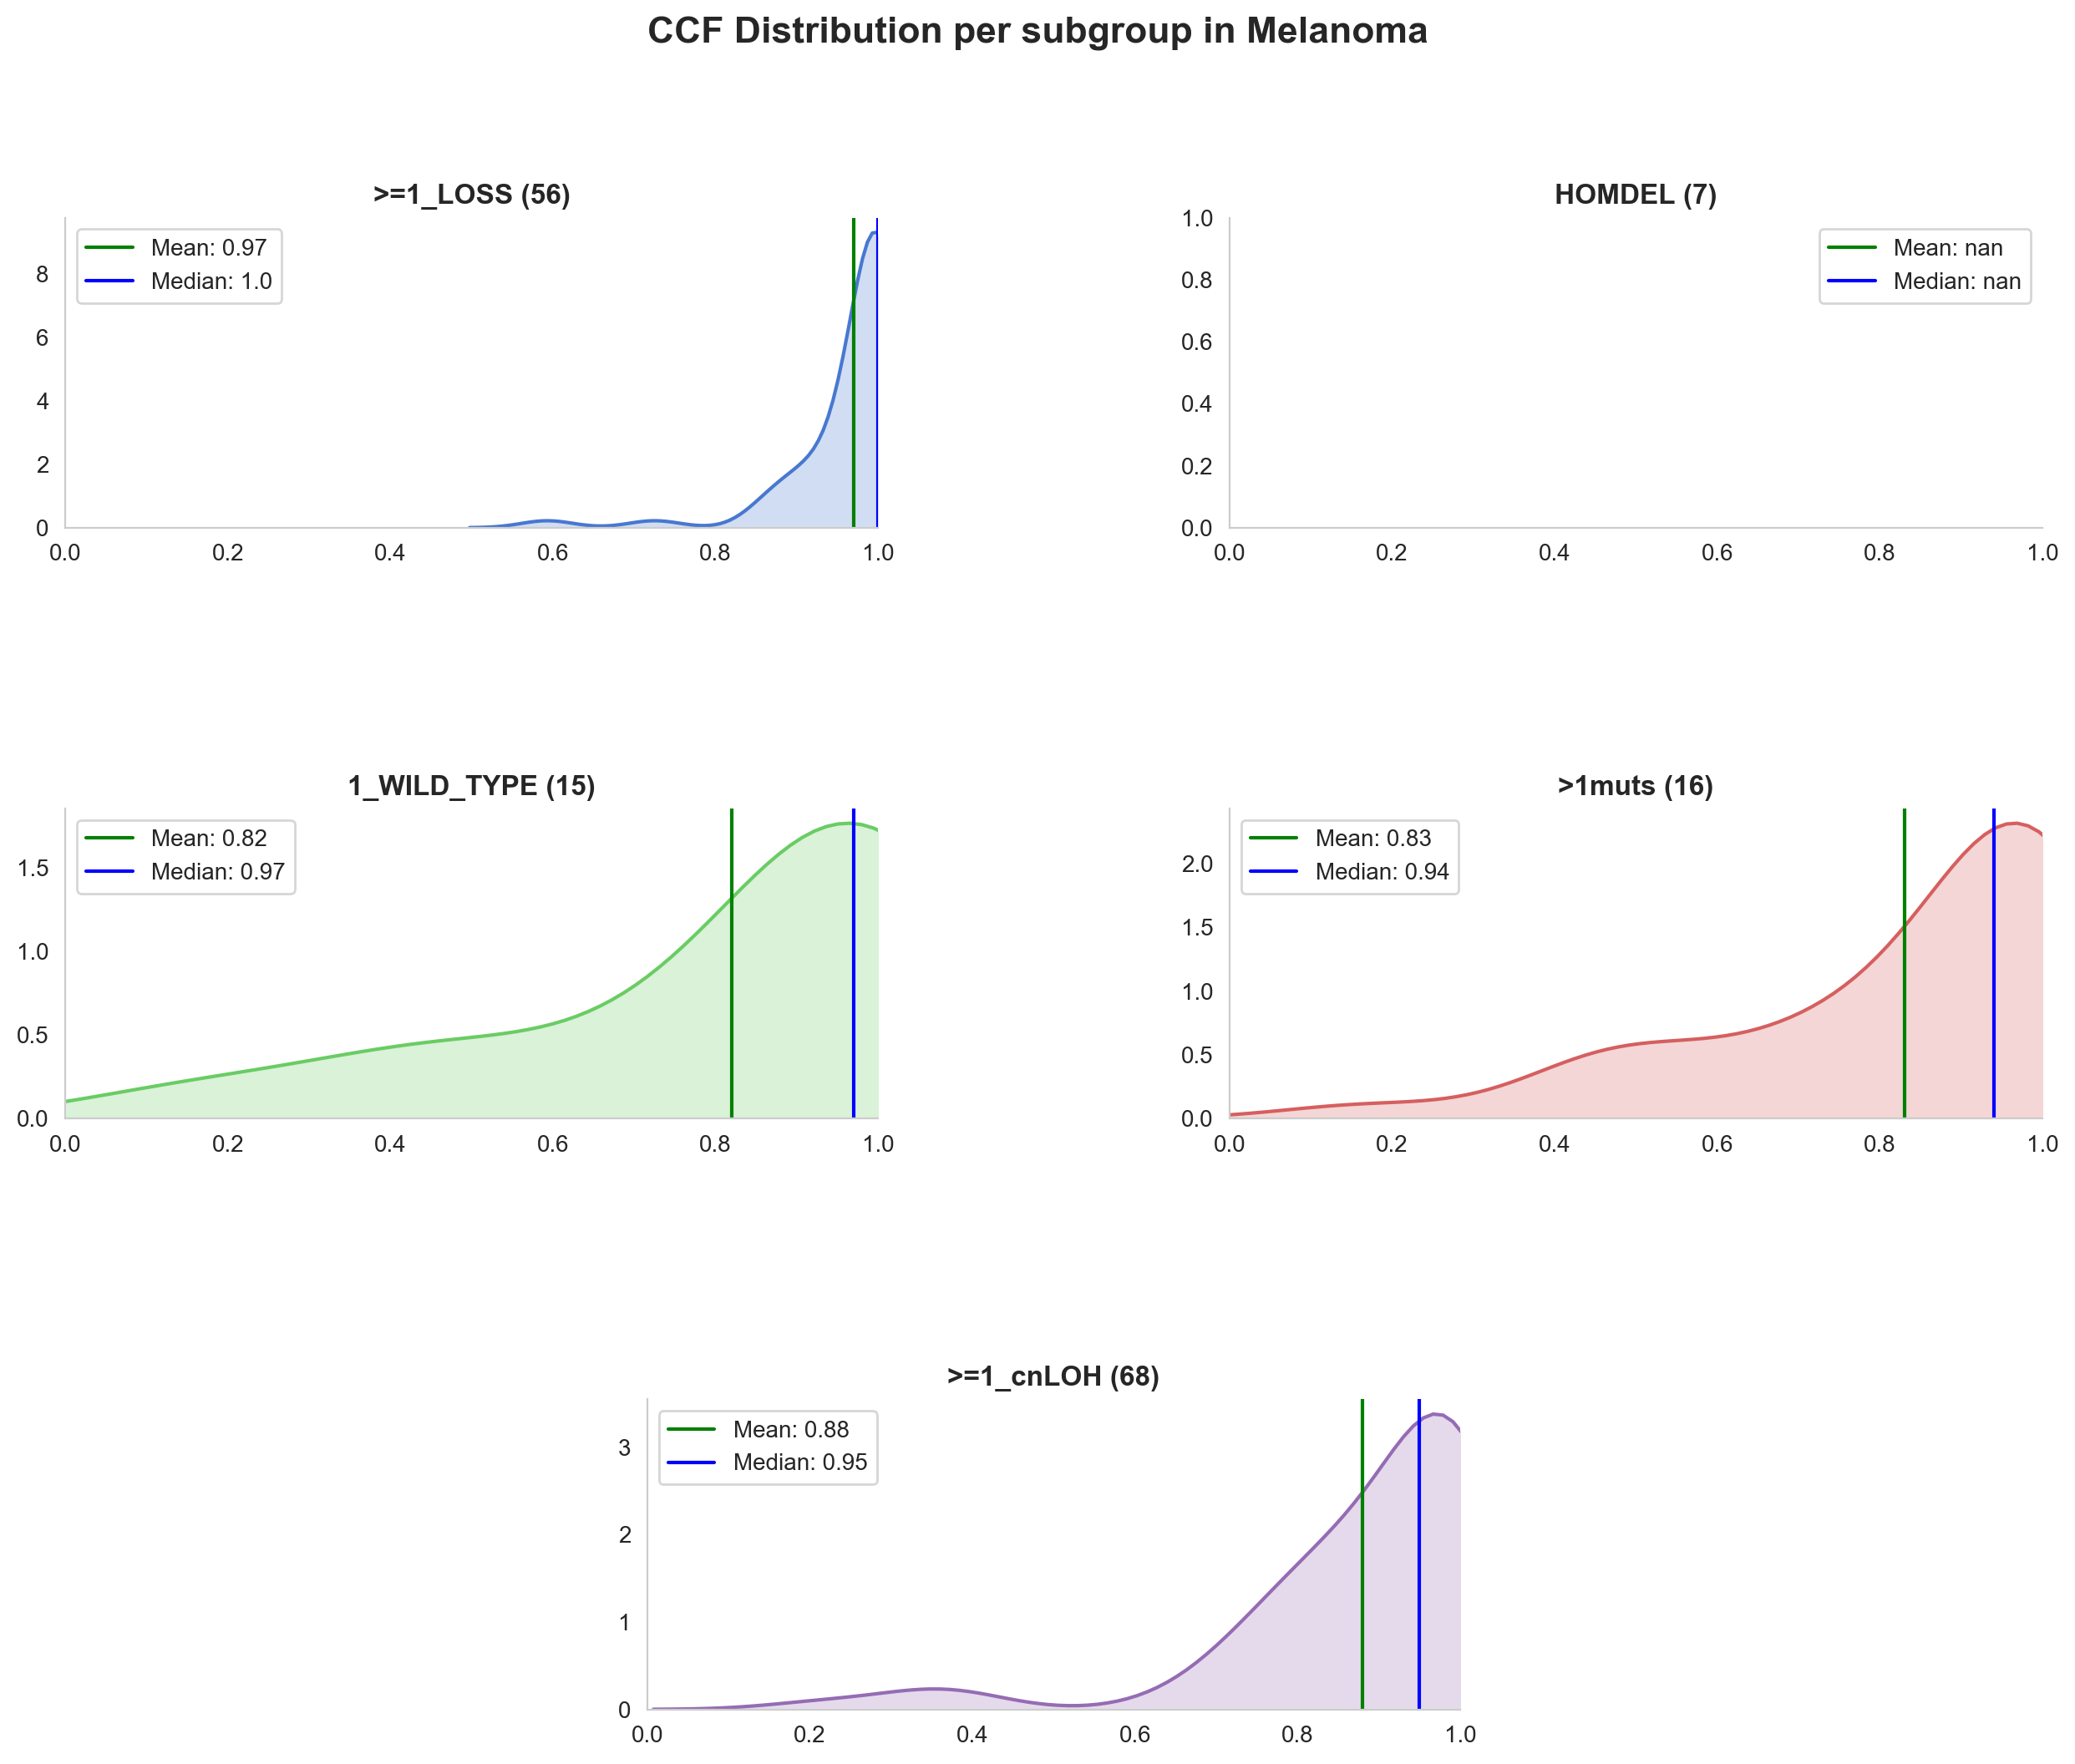

In [255]:
fig, ax = get_densities(master_cancer,
              metrics= 'tp53_ccf', 
              fig_title= 'CCF Distribution per subgroup in ' + cancer_type, 
              xlabel='', 
              ylabel='',  
              number=5, 
              tp53_metrics=True,
              met_prim = None, 
              clip = (0.0,3.0), 
              x_lim =[0,1])

## Scatter Plots (VAF, CCF)

In [112]:
def plot_scatters(data: pd.DataFrame, title:str, metrics: str, met_prim=False, figsize=(4,4)):
    fig=plt.figure(figsize=figsize)
    ax = plt.subplot2grid(shape=(1,1), loc=(0,0), colspan=1)
    
    data = data[data['tp53_count']>=2]
    if met_prim:
        data = data[data['Sample_Type'] == met_prim]
    data_ccf = data[[metrics + '_1', metrics + '_2',metrics + '_3',metrics + '_4',metrics + '_5']]
    max_table_ccf = pd.DataFrame(np.sort(data_ccf.fillna(0).values)[:,-2:], columns=['2nd-largest','largest'])
    max_table_ccf = pd.concat([max_table_ccf, data.reset_index().tp53_group], axis=1)
    #display(max_table_ccf)
    
    sns.scatterplot(x='largest', y='2nd-largest', data=max_table_ccf, ax=ax, hue='tp53_group', palette=palette, legend=False)
    ax.plot([0,1], [0,1], linewidth=0.5, color='grey')
    ax.set_ylabel(metrics + '_2')
    ax.set_xlabel(metrics + '_1')
    ax.set_title(title, weight = 'bold')
    ax.text(.5,.9, str(data.shape[0]) +' samples',
        horizontalalignment='center',
        transform=ax.transAxes)
    
    return fig, ax

### VAF

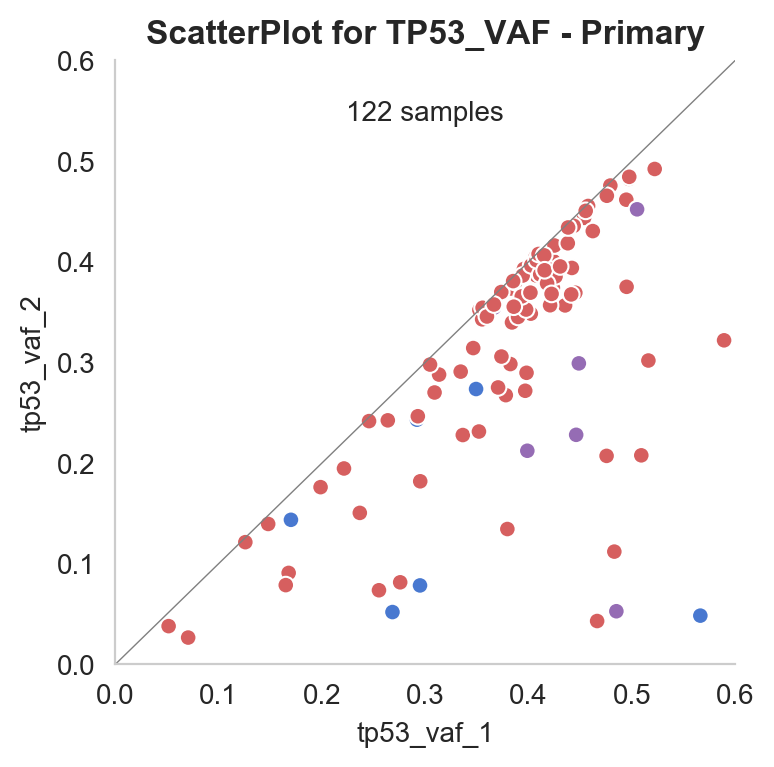

In [113]:
fig, ax = plot_scatters(master_cancer, 
              title='ScatterPlot for TP53_VAF - Primary', 
              metrics='tp53_vaf', 
              met_prim='Primary', 
              figsize=(4,4))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(0, 0.6)
ax.set_ylim(0, 0.6)
plt.show(fig)

In [118]:
fig, ax = plot_scatters(master_cancer, 
              title='ScatterPlot for TP53_VAF - Metastasis', 
              metrics='tp53_vaf', 
              met_prim='Metastasis', 
              figsize=(4,4))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_xlim(0, 0.6)
#ax.set_ylim(0, 0.6)
plt.show(fig)

TypeError: plot_scatters() got an unexpected keyword argument 'figsize'

### CCF

In [ ]:
fig, ax = plot_scatters(master_cancer, 
              title='ScatterPlot for TP53_CCF - Primary', 
              metrics='tp53_ccf', 
              met_prim='Primary', 
              figsize=(4,4))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_xlim(0, 0.6)
#ax.set_ylim(0, 0.6)
plt.show(fig)

In [ ]:
fig, ax = plot_scatters(master_cancer, 
              title='ScatterPlot for TP53_CCF - Metastasis', 
              metrics='tp53_ccf', 
              met_prim='Metastasis', 
              figsize=(4,4))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#ax.set_xlim(0, 0.6)
#ax.set_ylim(0, 0.6)
plt.show(fig)

# Genomic

## Genome Instability

### # of affected chromosomes

In [319]:
master_cancer_gi = master_cancer[master_cancer['chr_affected']!='NaN']
fig, ax = boxplot_sampletype(master_cancer_gi, 'chr_affected', figsize= (3,3), title='Number of affected chromosomes for '+cancer_type, title_font=12, xlim=[0,25])

TypeError: boxplot_sampletype() got an unexpected keyword argument 'figsize'

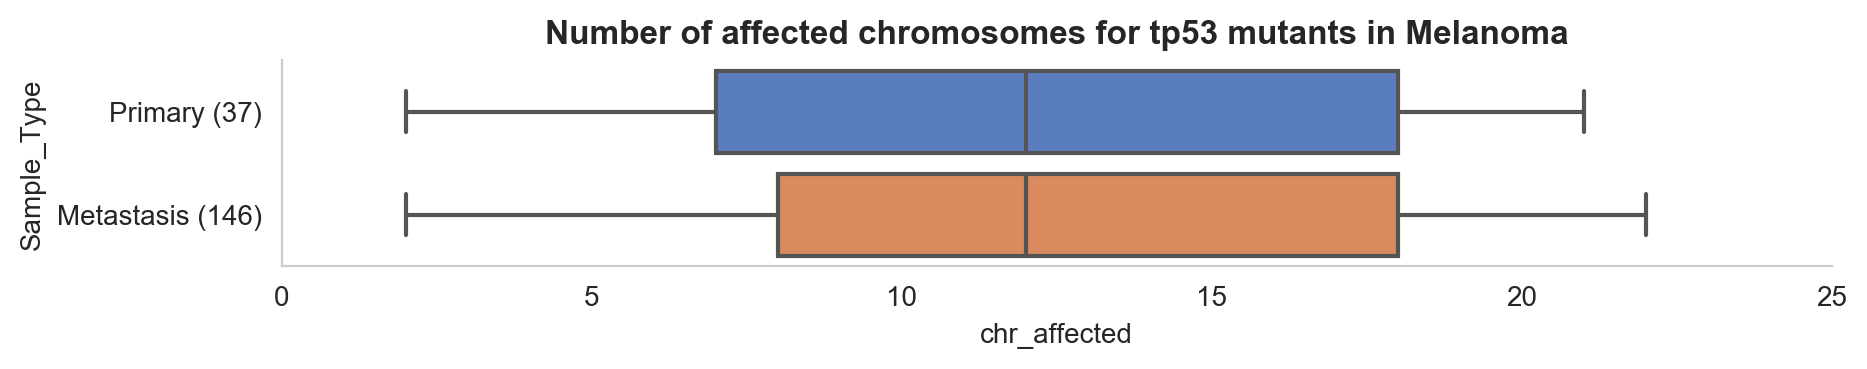

In [262]:
fig, ax = boxplot_sampletype(master_cancer_gi[master_cancer_gi['tp53_count']>=1], 'chr_affected', figsize= (10,3), title='Number of affected chromosomes for tp53 mutants in '+cancer_type, title_font=12, xlim=[0,25])

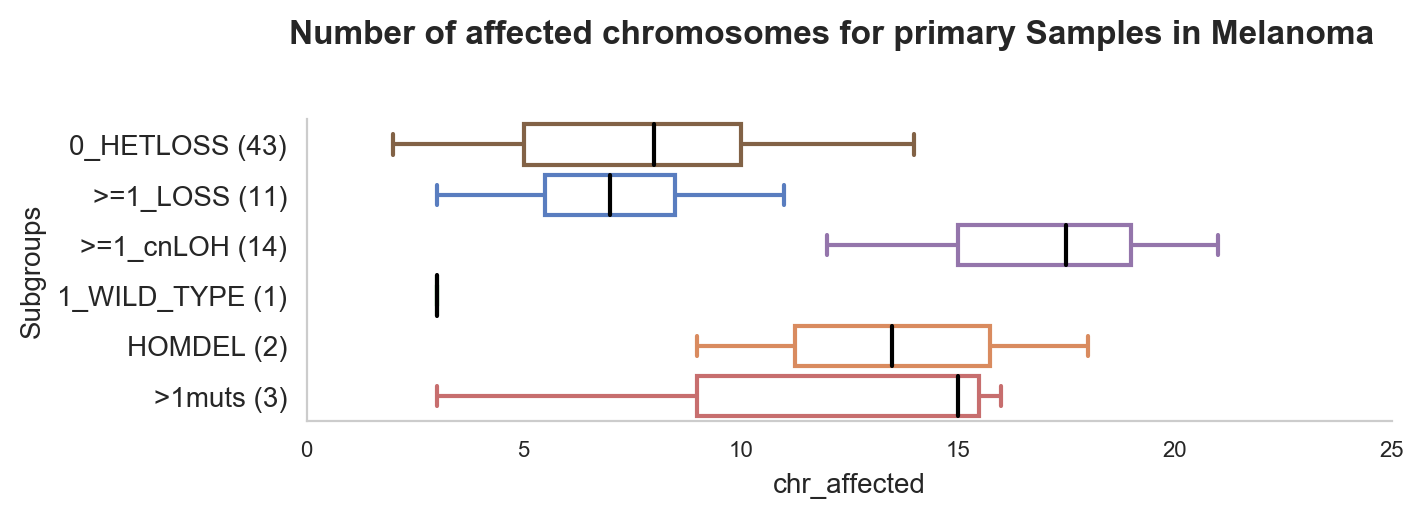

In [263]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='chr_affected', 
                         title= 'Number of affected chromosomes for primary Samples in ' + cancer_type, 
                         figsize = (7, 2),  
                         xlim=25, 
                         met_prim = 'Primary')

plt.show(fig)

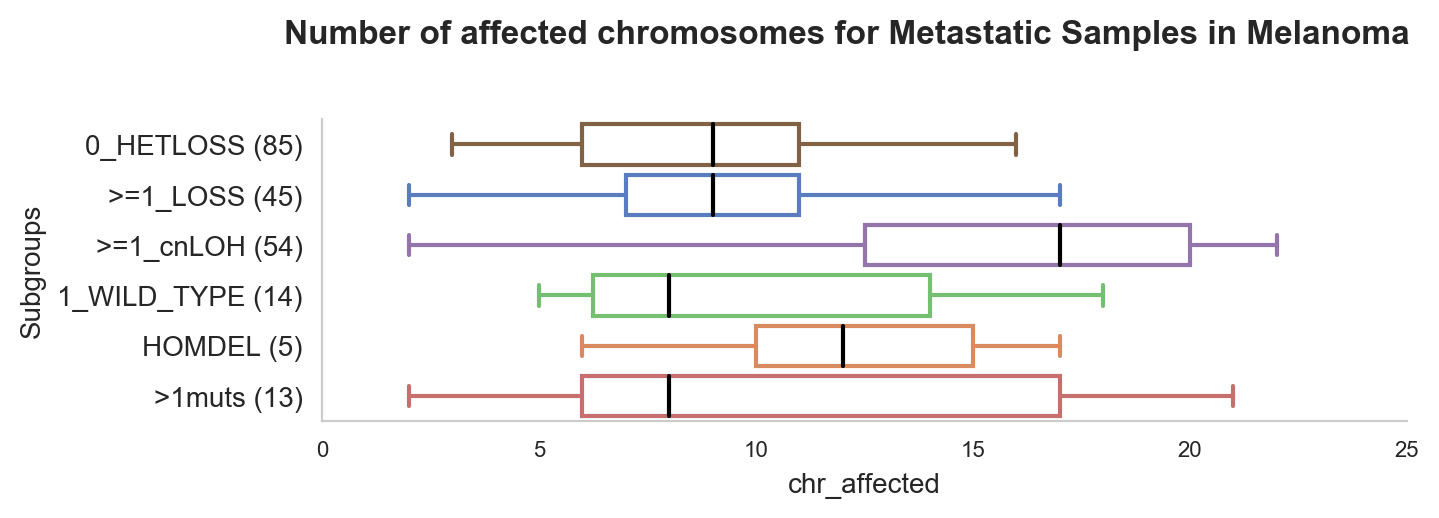

In [264]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='chr_affected', 
                         title= 'Number of affected chromosomes for Metastatic Samples in ' + cancer_type, 
                         figsize = (7, 2),  
                         xlim=25, 
                         met_prim = 'Metastasis')

plt.show(fig)

### # of chromosomes affected by a LOSS

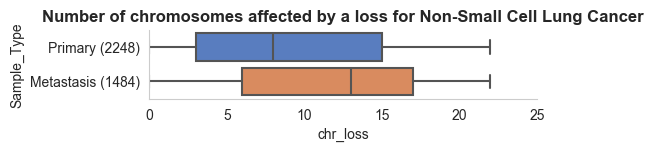

In [9]:
master_cancer_gi = master_cancer[master_cancer['chr_loss']!='NaN']
fig, ax = boxplot_sampletype(master_cancer_gi, 'chr_loss', figsize= (5,2), title='Number of chromosomes affected by a loss for '+cancer_type, title_font=12, xlim=[0,25])

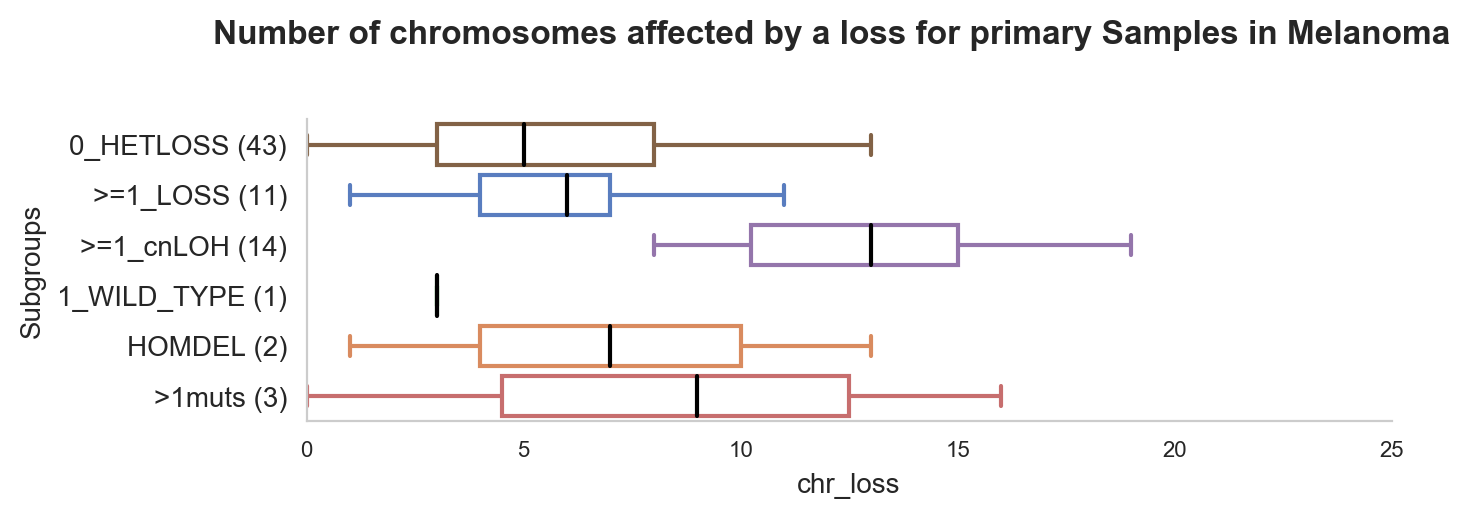

In [266]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='chr_loss', 
                         title= 'Number of chromosomes affected by a loss for primary Samples in ' + cancer_type, 
                         figsize = (7, 2),  
                         xlim=25, 
                         met_prim = 'Primary')

plt.show(fig)

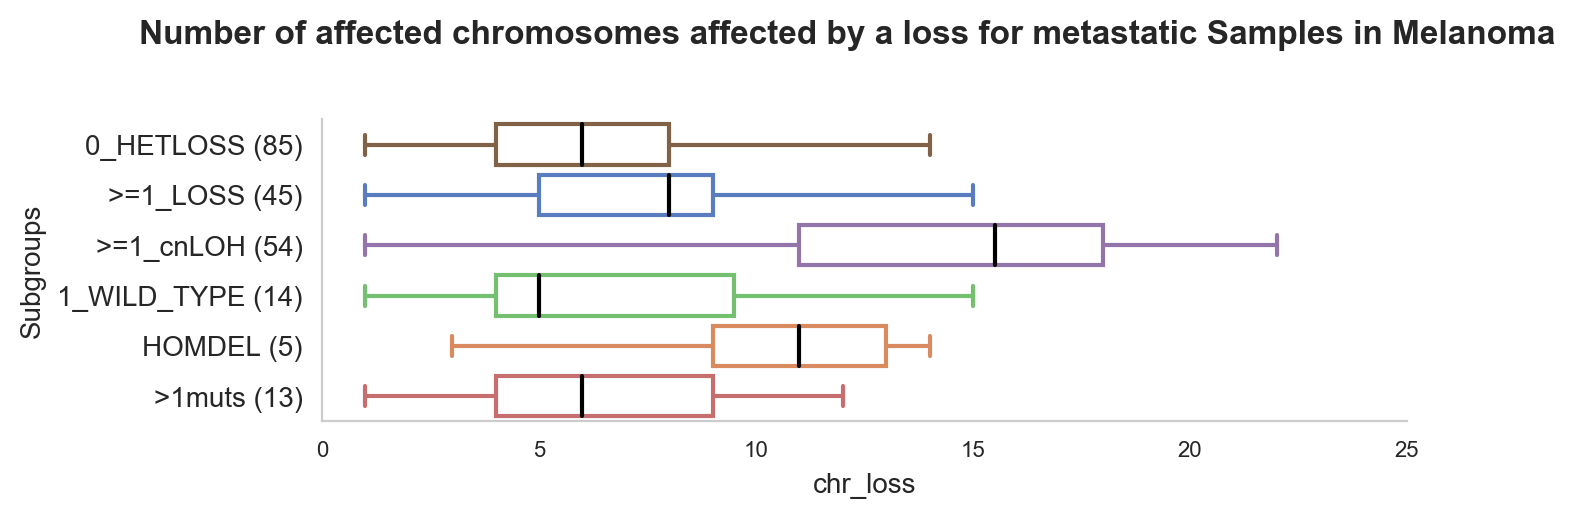

In [267]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='chr_loss', 
                         title= 'Number of affected chromosomes affected by a loss for metastatic Samples in ' + cancer_type, 
                         figsize = (7, 2),  
                         xlim=25, 
                         met_prim = 'Metastasis')

plt.show(fig)

### # of chromosomes affected by a CNLOH

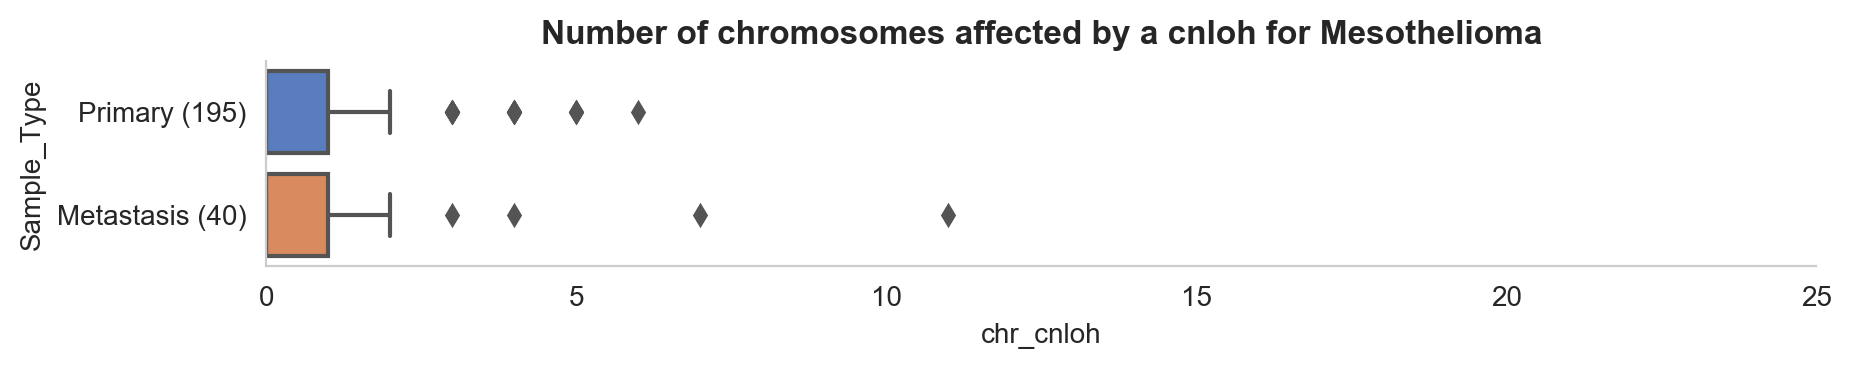

In [273]:
master_cancer_gi = master_cancer[master_cancer['chr_cnloh']!='NaN']
fig, ax = boxplot_sampletype(master_cancer_gi, 'chr_cnloh', figsize= (10,3), title='Number of chromosomes affected by a cnloh for '+cancer_type, title_font=12, xlim=[0,25])

(<Figure size 700x200 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x130eb9e10>)

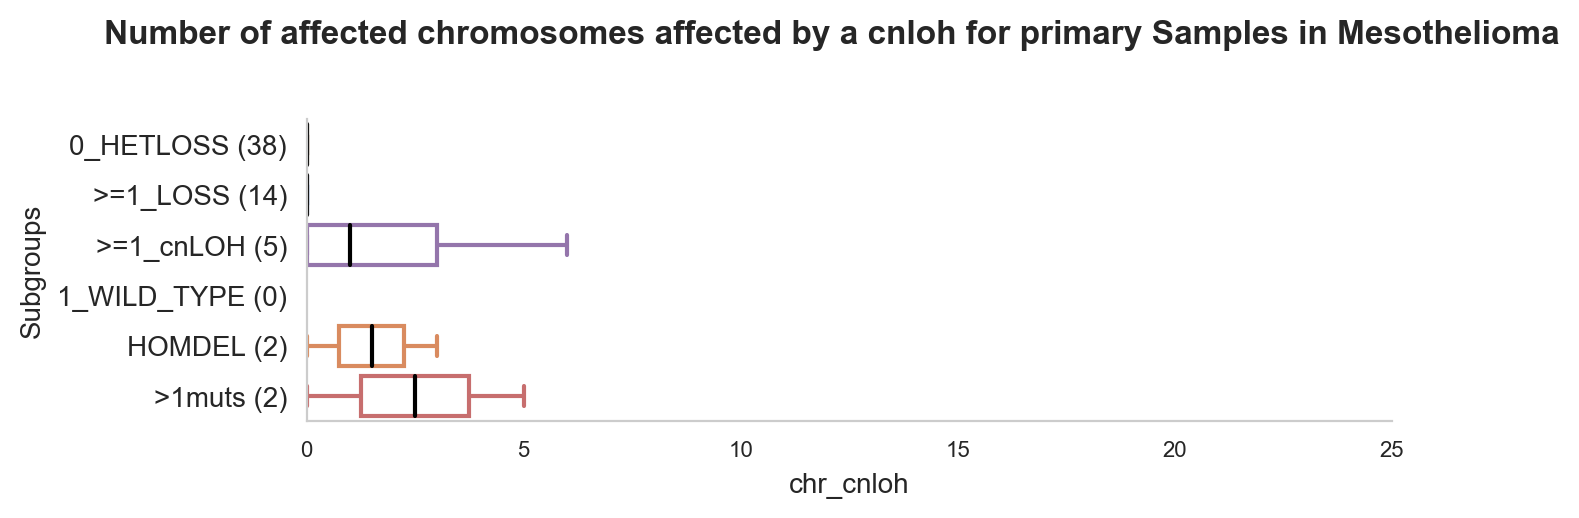

In [289]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='chr_cnloh', 
                         title= 'Number of affected chromosomes affected by a cnloh for primary Samples in ' + cancer_type, 
                         figsize = (7, 2),  
                         xlim=25, 
                         met_prim = 'Primary')

plt.show(fig)

(<Figure size 700x200 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13b5878d0>)

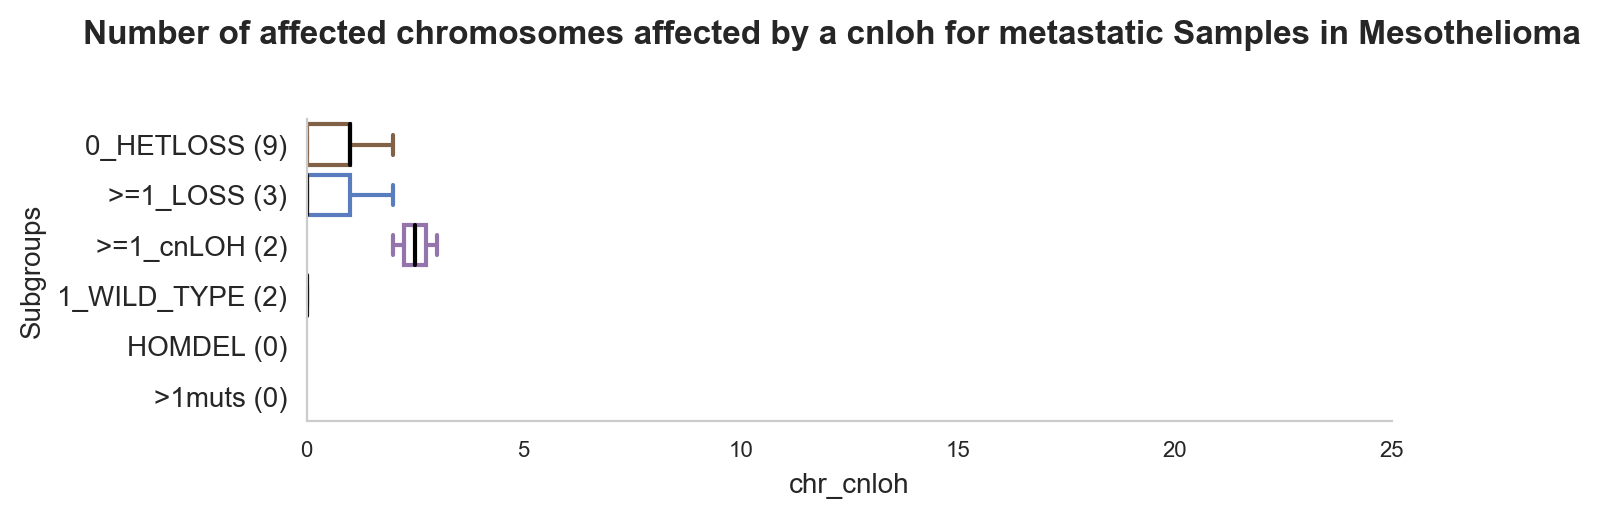

In [290]:
fig, ax = plot_mut_count_subgroups(master_cancer, 
                         cancer_type, 
                         metrics='chr_cnloh', 
                         title= 'Number of affected chromosomes affected by a cnloh for metastatic Samples in ' + cancer_type, 
                         figsize = (7, 2),  
                         xlim=25, 
                         met_prim = 'Metastasis')

plt.show(fig)

## Mutational Landscape

## Mutation Count

## Tumor Mutational Burden

## MSI Score

## TP53 Metrics

### Hotspot distribution

            count
tp53_spots       
248            27
273            19
175            17
342            14
280            13
220            11
285            11
176            11
196            10
245            10
306            10
241             8
213             8
337             7
282             7
194             6
271             6
272             6
274             6
163             6
180             5
262             5
179             5
287             5
286             5
135             5
255             5
249             5
172             5
192             5
195             5
270             4
339             4
127             4
193             4
278             4
242             4
141             4
133             4
146             4
132             4
237             4
204             4
215             3
236             3
259             3
73              3
113             3
209             3
244             3
110             3
205             3
246             3
134       

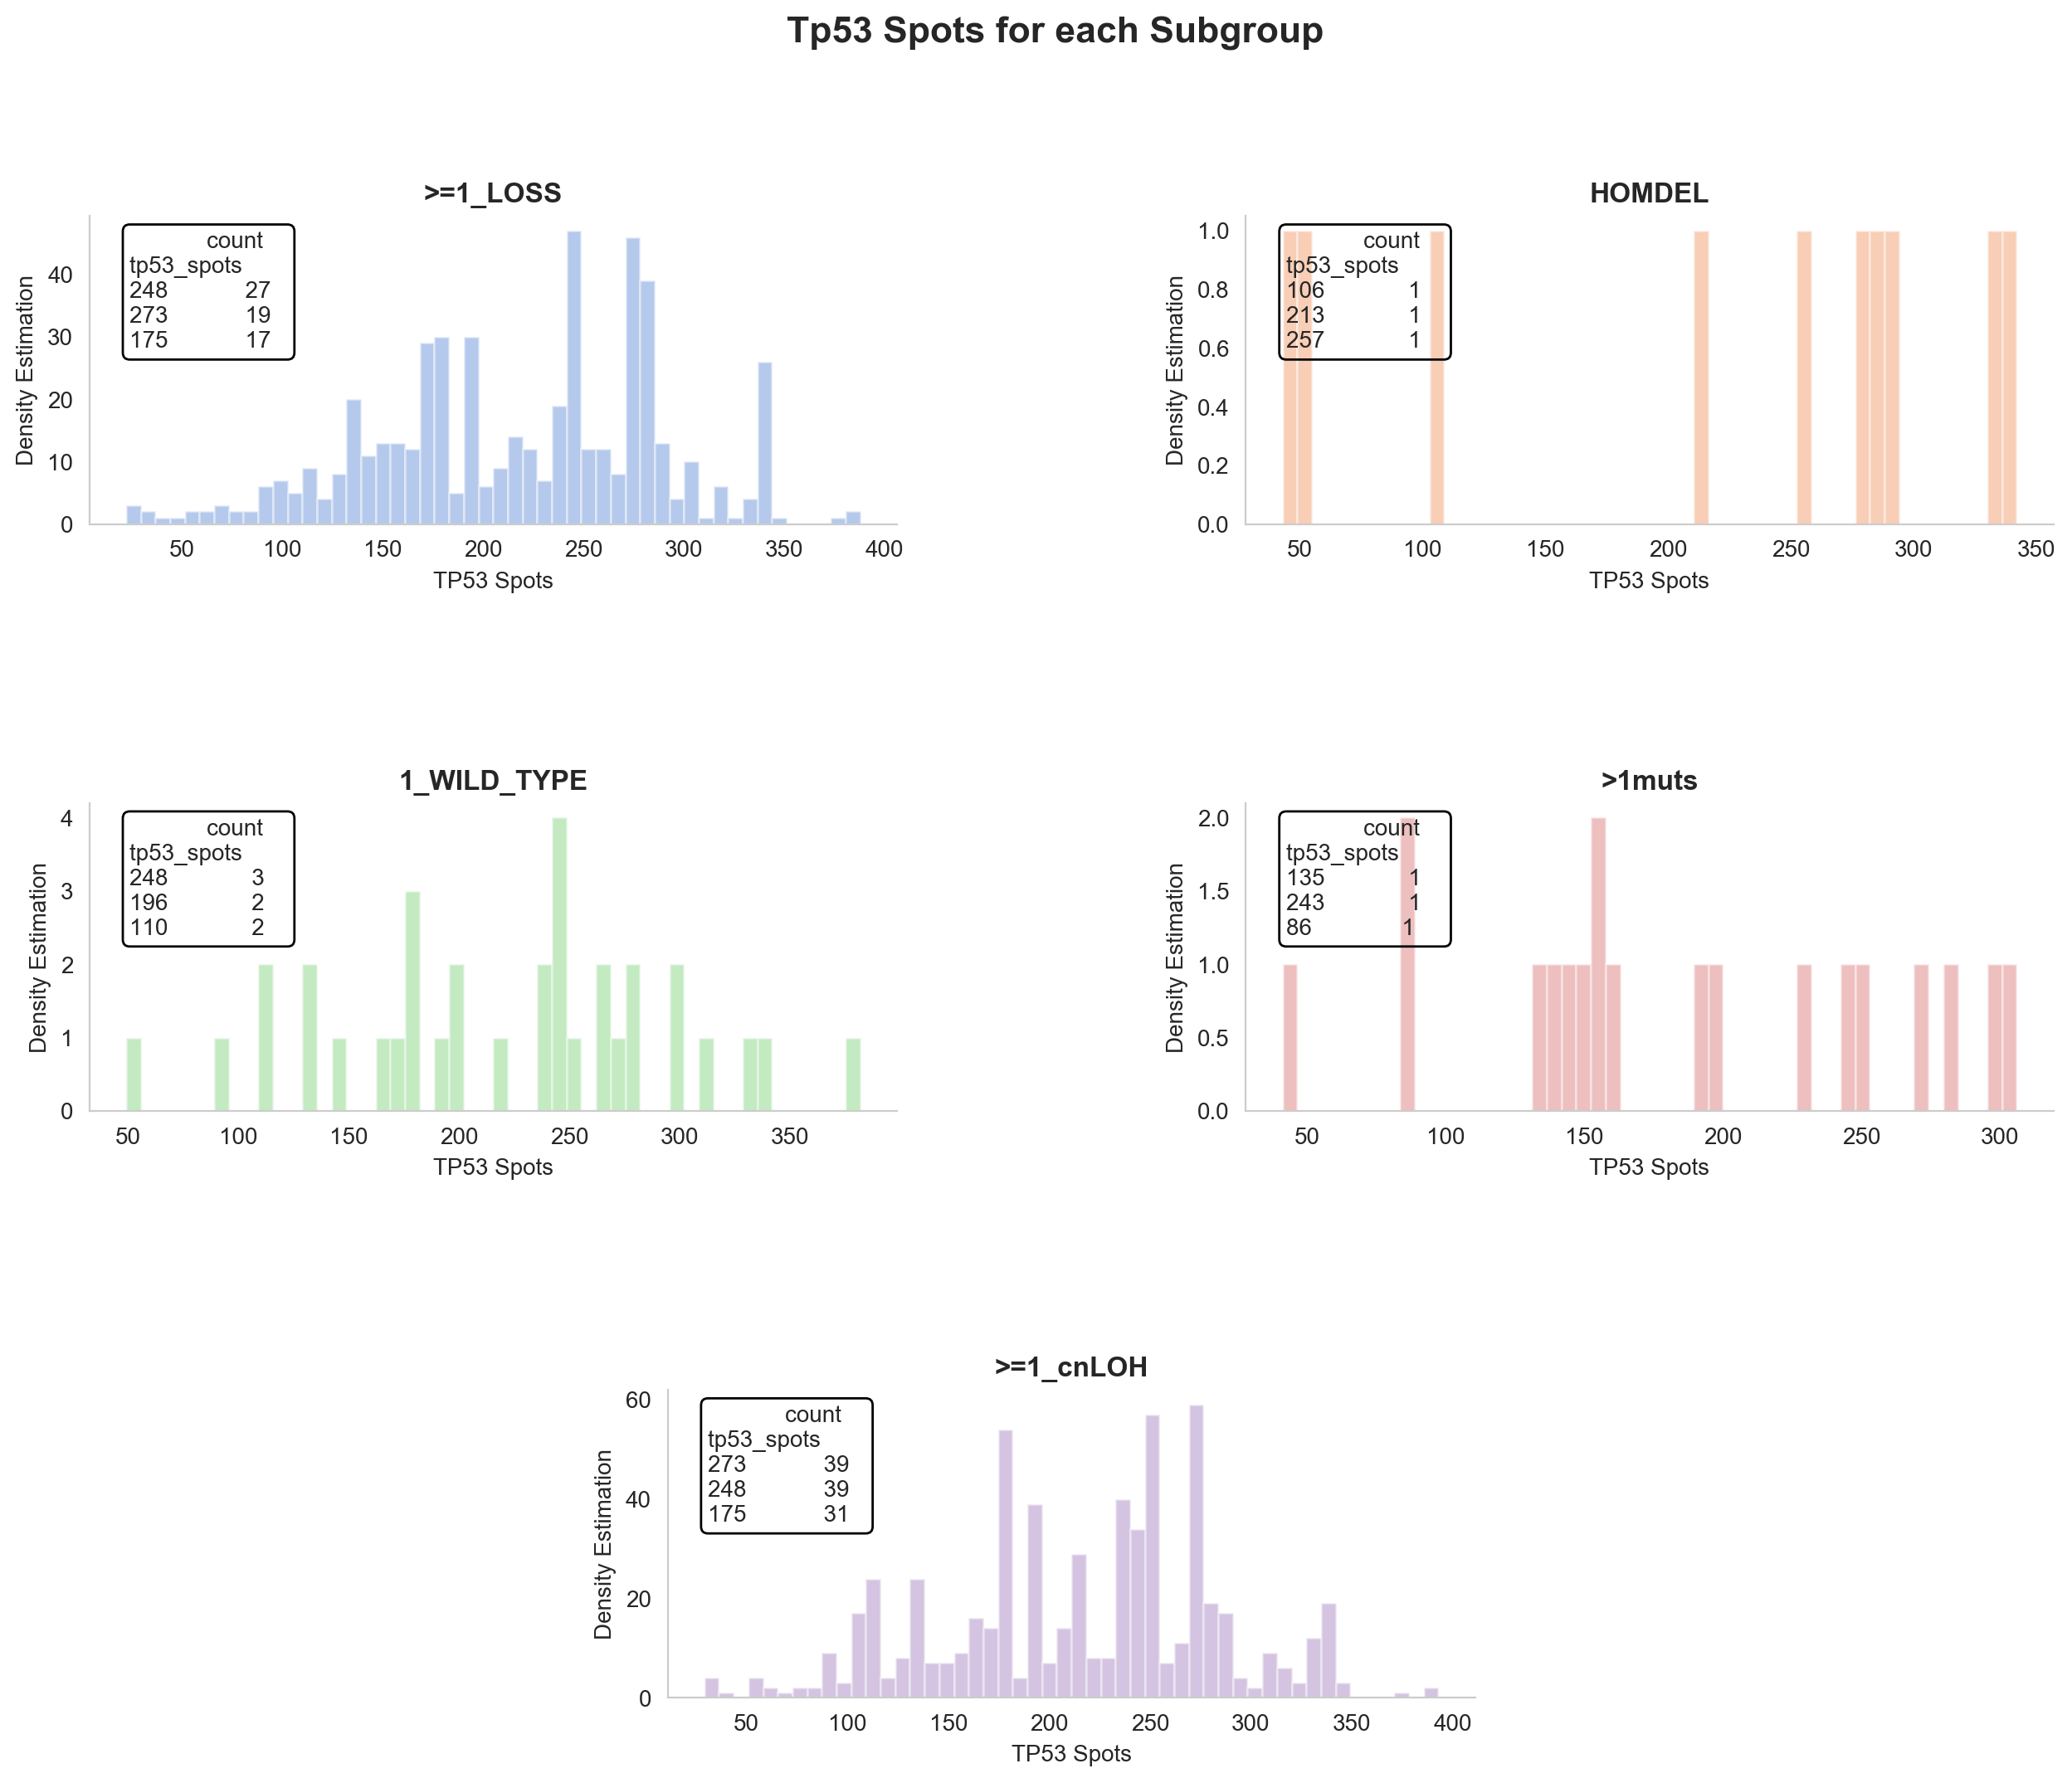

In [79]:
fig = def_fig_set(number = 5)
fig.tight_layout(pad=10, w_pad=0.5, h_pad=10)
fig.suptitle('Tp53 Spots for each Subgroup', fontsize=16, weight='bold')

groups = ['>=1_LOSS', 'HOMDEL', '1_WILD_TYPE', '>1muts', '>=1_cnLOH', '0_HETLOSS']
for ax, subgroup,i in zip(fig.axes, groups, range(len(groups))):
    data = master_cancer[master_cancer['tp53_group'] == subgroup]
    
    data_spots = list(data['tp53_spot_1']) + list(data['tp53_spot_2']) + list(data['tp53_spot_3']) + list(data['tp53_spot_4']) + list(data['tp53_spot_5'])
    data_spot_df = pd.DataFrame(data_spots, columns=['tp53_spots']).dropna()
    data_spot_df = data_spot_df[data_spot_df['tp53_spots'] !='nan']
    count = pd.DataFrame(data_spot_df.groupby(['tp53_spots']).size(), columns=['count']).sort_values(by=['count'], ascending=False)
    print(count)
    #count.index = count.index.drop('nan')
    count = pd.DataFrame(count, index = count.index).head(3)
    
    sns.distplot(data_spot_df, bins=50, kde=False, color=my_colors[i], ax=ax)
    ax.set_xlabel('TP53 Spots')
    ax.set_ylabel('Density Estimation')
    ax.set_title(subgroup, weight = 'bold')
    ax.text(.05, .95, str(count), transform=ax.transAxes, ha="left", va="top", bbox=dict(facecolor='none', edgecolor='black', boxstyle='round'))

### Mutation Type

count_tp53_vc_group
tp53_vc_group                     
missense                       817
truncated                      606
in_frame                        50

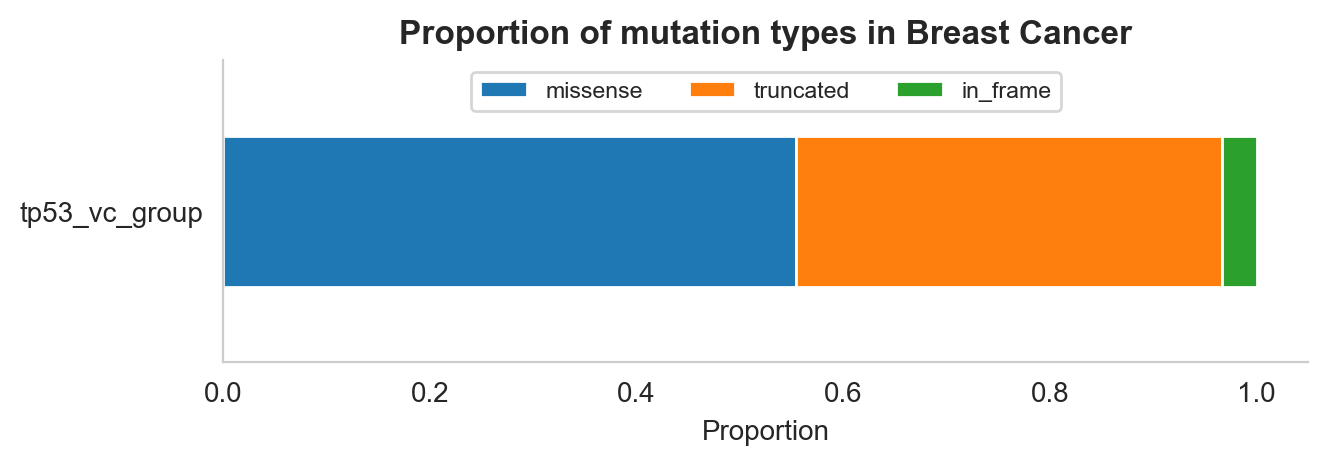

In [80]:
fig, ax = proportion_plot(master_cancer, 
                        metrics='tp53_vc_group',
                        title= 'Proportion of mutation types in ' + cancer_type,
                        figsize=(7,2),
                        display_table=True,
                        tp53_metrics=True,
                        ncol_legend =3)

['175', 'in_frame', '248', '273', 'hotspot', 'truncated', 'missense']


in_frame  175   248  hotspot   273  truncated  missense  \
1_WILD_TYPE | P       0.0  0.0   0.0      3.0   3.0       12.0      12.0   
1_WILD_TYPE | M       0.0  1.0   1.0      1.0   4.0       14.0      34.0   
>1muts | P            2.0  1.0   0.0      2.0   4.0       14.0     127.0   
>1muts | M            2.0  1.0   1.0      4.0   4.0       21.0      91.0   
>=1_LOSS | P          3.0  5.0   7.0      7.0   9.0       95.0     109.0   
>=1_LOSS | M          5.0  5.0   9.0     14.0   9.0      117.0     420.0   
>=1_cnLOH | P         9.0  9.0  25.0     21.0  17.0      156.0     818.0   
>=1_cnLOH | M        13.0  6.0  22.0     30.0  15.0      166.0     226.0   

                 175_r  in_frame_r  248_r  273_r  hotspot_r  truncated_r  \
1_WILD_TYPE | P  0.000       0.000  0.000  0.100      0.100        0.400   
1_WILD_TYPE | M  0.018       0.000  0.018  0.073      0.018        0.255   
>1muts | P       0.007       0.013  0.000  0.027      0.013        0.093   
>1muts | M       0.008       0.016  0.008  0.032      0.032        0.169   
>=1_LOSS | P     0.021       0.013  0.030  0.038      0.030        0.404   
>=1_LOSS | M     0.009       0.009  0.016  0.016      0.024        0.202   
>=1_cnLOH | P    0.009       0.009  0.024  0.016      0.020        0.148   
>=1_cnLOH | M    0.013       0.027  0.046  0.031      0.063        0.347   

                 missense_r   sum_p  sum_m  
1_WILD_TYPE | P       0.400    30.0    0.0  
1_WILD_TYPE | M       0.618     0.0   55.0  
>1muts | P            0.847   150.0    0.0  
>1muts | M            0.734     0.0  124.0  
>=1_LOSS | P          0.464   235.0    0.0  
>=1_LOSS | M          0.725     0.0  579.0  
>=1_cnLOH | P         0.775  1055.0    0.0  
>=1_cnLOH | M         0.473     0.0  478.0

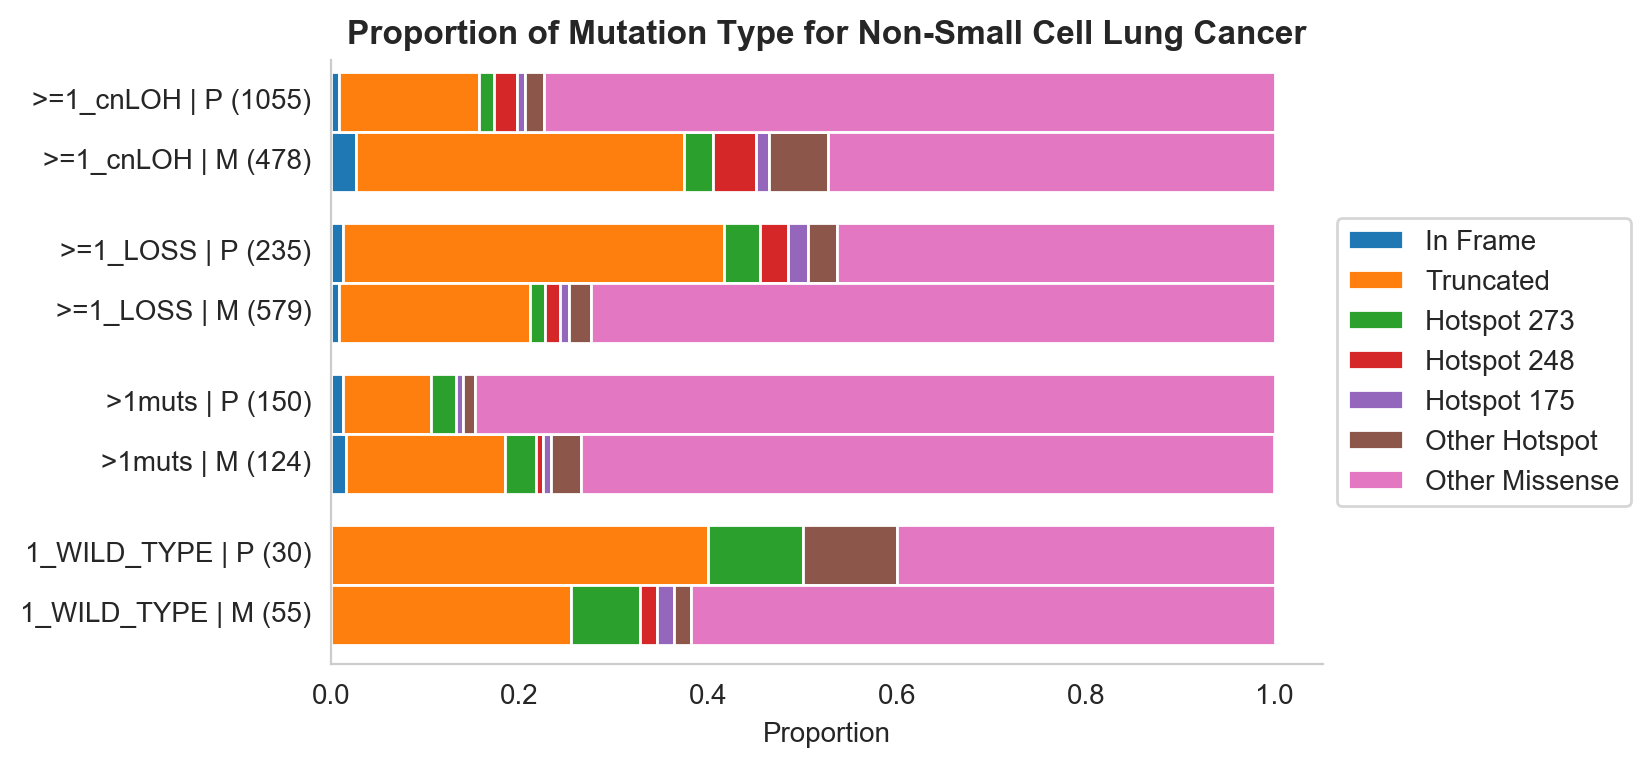

In [325]:
mut_subgroups = ['>=1_LOSS', '>=1_cnLOH', '1_WILD_TYPE', 'HOMDEL', '>1muts']
for subgroup in mut_subgroups:
    data_prim = master_cancer[master_cancer['tp53_group'] == subgroup][master_cancer['Sample_Type'] == 'Primary']
    data_met = master_cancer[master_cancer['tp53_group'] == subgroup][master_cancer['Sample_Type'] == 'Metastasis']
    data_1m = get_groupby(data_prim,'tp53_vc_group_1', 'count'); data_2p = get_groupby(data_prim,'tp53_vc_group_2', 'count'); data_3p = get_groupby(data_prim,'tp53_vc_group_3', 'count') ; data_4p = get_groupby(data_prim,'tp53_vc_group_4', 'count') ; data_5p = get_groupby(data_prim,'tp53_vc_group_5', 'count') 
    data_1p = get_groupby(data_met,'tp53_vc_group_1', 'count'); data_2m = get_groupby(data_met,'tp53_vc_group_2', 'count'); data_3m = get_groupby(data_met,'tp53_vc_group_3', 'count') ; data_4m = get_groupby(data_met,'tp53_vc_group_4', 'count') ; data_5m = get_groupby(data_met,'tp53_vc_group_5', 'count') 
    count_m = (data_1m+data_2m+data_3m+data_4m+data_5m).fillna(data_1m).fillna(data_2m).fillna(data_3m).fillna(data_4m).fillna(data_5m).sort_values(by=['count'])
    count_p = (data_1p+data_2p+data_3p+data_4p+data_5p).fillna(data_1p).fillna(data_2p).fillna(data_3p).fillna(data_4p).fillna(data_5p).sort_values(by=['count'])
    count_m.columns=[subgroup] ; count_p.columns=[subgroup]
    if subgroup == '>=1_LOSS': countm = count_m ; countp = count_p
        
    else: countm = pd.concat([countm, count_m], axis=1) ; countp = pd.concat([countp, count_p], axis=1)
        
countm = countm.T.fillna(0) ; countp = countp.T.fillna(0)

columns_m = list(countm.columns)
columns_p = list(countm.columns)
print(columns_p)

for column in columns_m:
    countm[column + '_r'] = countm.apply(lambda x: round(x[column]/x[columns_m].sum(),3), axis=1)
for column in columns_p:   
    countp[column + '_r'] = countp.apply(lambda x: round(x[column]/x[columns_m].sum(),3), axis=1)
countp['sum_p'] = countp[columns_p].sum(axis=1) ; countm['sum_m'] = countm[columns_m].sum(axis=1)
countm = countm.set_index(pd.Series(['>=1_LOSS | M', '>=1_cnLOH | M', '1_WILD_TYPE | M', 'HOMDEL | M', '>1muts | M']))
countp = countp.set_index(pd.Series(['>=1_LOSS | P', '>=1_cnLOH | P', '1_WILD_TYPE | P', 'HOMDEL | P', '>1muts | P']))

count = pd.concat([countp, countm], axis=0).fillna(0)
count = count.reindex(['1_WILD_TYPE | P','1_WILD_TYPE | M', '>1muts | P', '>1muts | M'
                       ,'>=1_LOSS | P','>=1_LOSS | M', '>=1_cnLOH | P', '>=1_cnLOH | M',
                        'HOMDEL | P','HOMDEL | M'])

count = count.drop(['HOMDEL | P', 'HOMDEL | M'])
display(count)

fig, ax = get_mstacked_plot(count[['in_frame_r','truncated_r', '273_r', '248_r', '175_r','hotspot_r', 'missense_r']], 
                  'Proportion of Mutation Type for ' + cancer_type,
                  ['In Frame', 'Truncated', 'Hotspot 273','Hotspot 248','Hotspot 175', 'Other Hotspot', 'Other Missense'],
                  'Proportion',
                  'Subgroups',
                  figsize = (8,4),
                  horiz=True)

        


ax.set_ylabel('')

for container in ax.containers:
    for i, child in enumerate(container.get_children()):
        child.set_height(0.8)
        if i%2 == 1:
            child.set_y(child.get_y() - 0.2)
     
for container in ax.containers:
    for i, child in enumerate(container.get_children()):
        if i%2 == 1: child.set_y(child.get_y() - child.get_height())  
        if i%2 == 0: child.set_y(child.get_y() + child.get_height())

try:
        ax.set_yticklabels(['1_WILD_TYPE | P ('+ str(int(count.loc['1_WILD_TYPE | P', 'sum_p'])) + ')',
                            '1_WILD_TYPE | M ('+ str(int(count.loc['1_WILD_TYPE | M', 'sum_m'])) + ')',
                            '>1muts | P ('+ str(int(count.loc['>1muts | P', 'sum_p'])) + ')',
                            '>1muts | M ('+ str(int(count.loc['>1muts | M', 'sum_m'])) + ')',
                            '>=1_LOSS | P ('+ str(int(count.loc['>=1_LOSS | P', 'sum_p'])) + ')',
                            '>=1_LOSS | M ('+ str(int(count.loc['>=1_LOSS | M', 'sum_m'])) + ')',
                            '>=1_cnLOH | P ('+ str(int(count.loc['>=1_cnLOH | P', 'sum_p'])) + ')',
                            '>=1_cnLOH | M ('+ str(int(count.loc['>=1_cnLOH | M', 'sum_m'])) + ')'],
                             fontsize=10)
except: pass


ax.set_yticks([1, 0.2, 3,2.2, 5, 4.2, 7, 6.2])

# Clinical

## Age

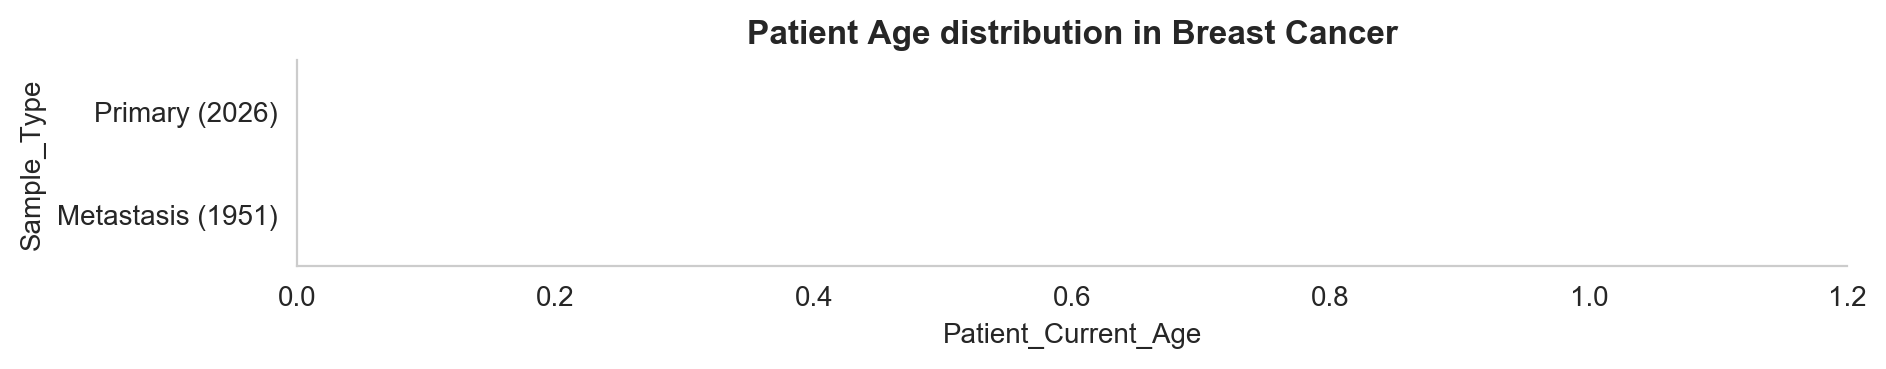

In [88]:
fig, ax = boxplot_sampletype(master_cancer, 
                             'Patient_Current_Age', 
                             figsize= (10,3), 
                             title='Patient Age distribution in ' + cancer_type, 
                             title_font=12,
                             tp53_metrics=False,
                             xlim=[0,1.2])

## Sex

count_Sex
Sex              
Female       3930
Male           36

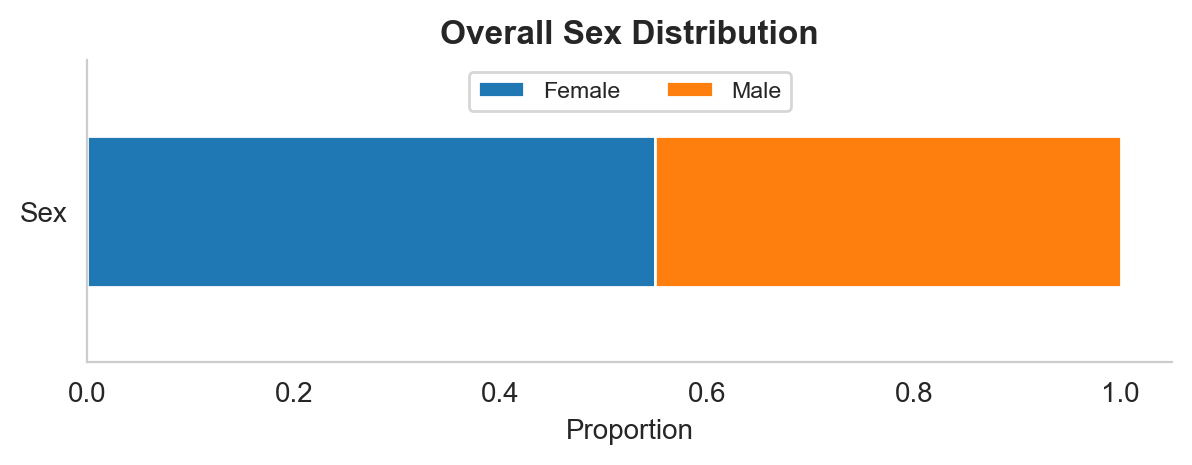

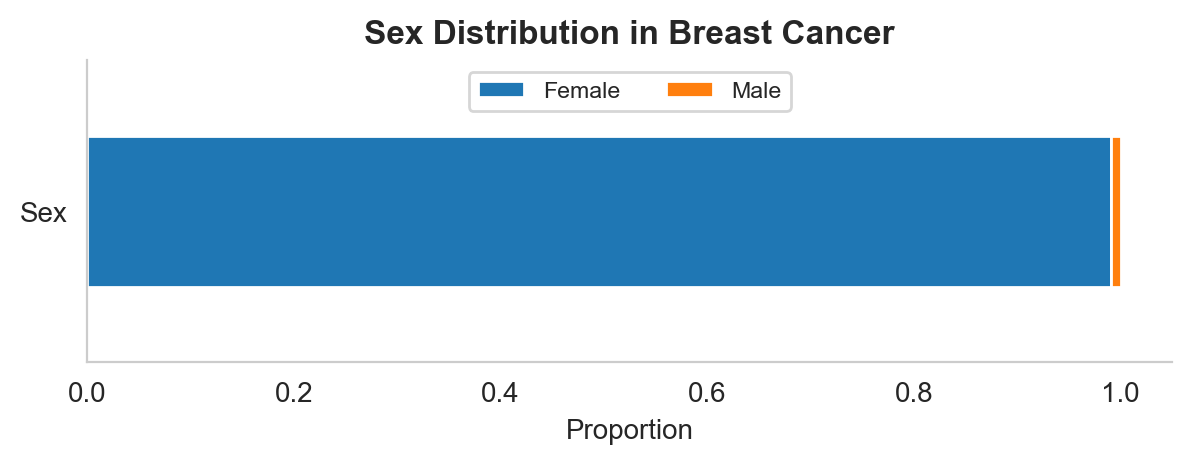

In [83]:
fig, ax = proportion_plot(master, 
                metrics='Sex',
                title= 'Overall Sex Distribution',
                figsize=(7,2),
                display_table=False, 
                ncol_legend =6)

fig, ax = proportion_plot(master_cancer, 
                metrics='Sex',
                title= 'Sex Distribution in ' + cancer_type,
                figsize=(7,2),
                display_table=True, 
                ncol_legend =6)

count_Race_Category
Race_Category                                      
WHITE                                         21233
ASIAN-FAR EAST/INDIAN SUBCONT                  1914
BLACK OR AFRICAN AMERICAN                      1796
PT REFUSED TO ANSWER                            932
OTHER                                           711
NO VALUE ENTERED                                567
UNKNOWN                                         143
NATIVE AMERICAN-AM IND/ALASKA                    51
NATIVE HAWAIIAN OR PACIFIC ISL                   10

count_Race_Category
Race_Category                                     
WHITE                                         2889
BLACK OR AFRICAN AMERICAN                      365
ASIAN-FAR EAST/INDIAN SUBCONT                  273
OTHER                                          140
PT REFUSED TO ANSWER                           136
NO VALUE ENTERED                               127
UNKNOWN                                         30
NATIVE AMERICAN-AM IND/ALASKA                    6

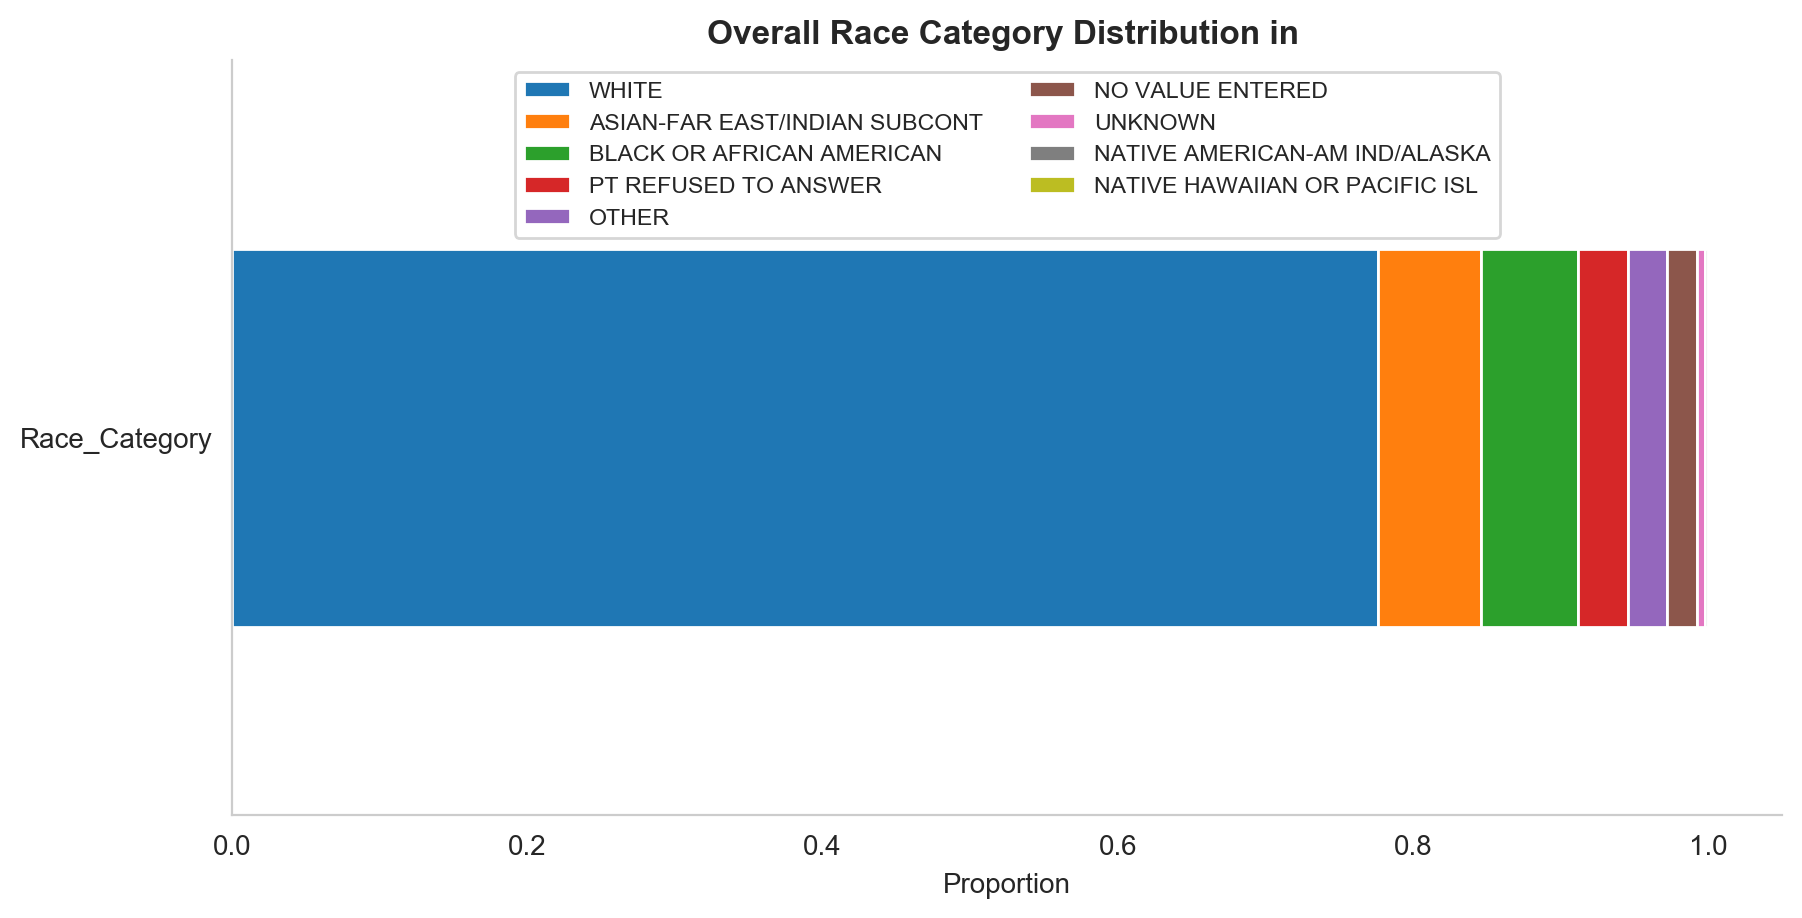

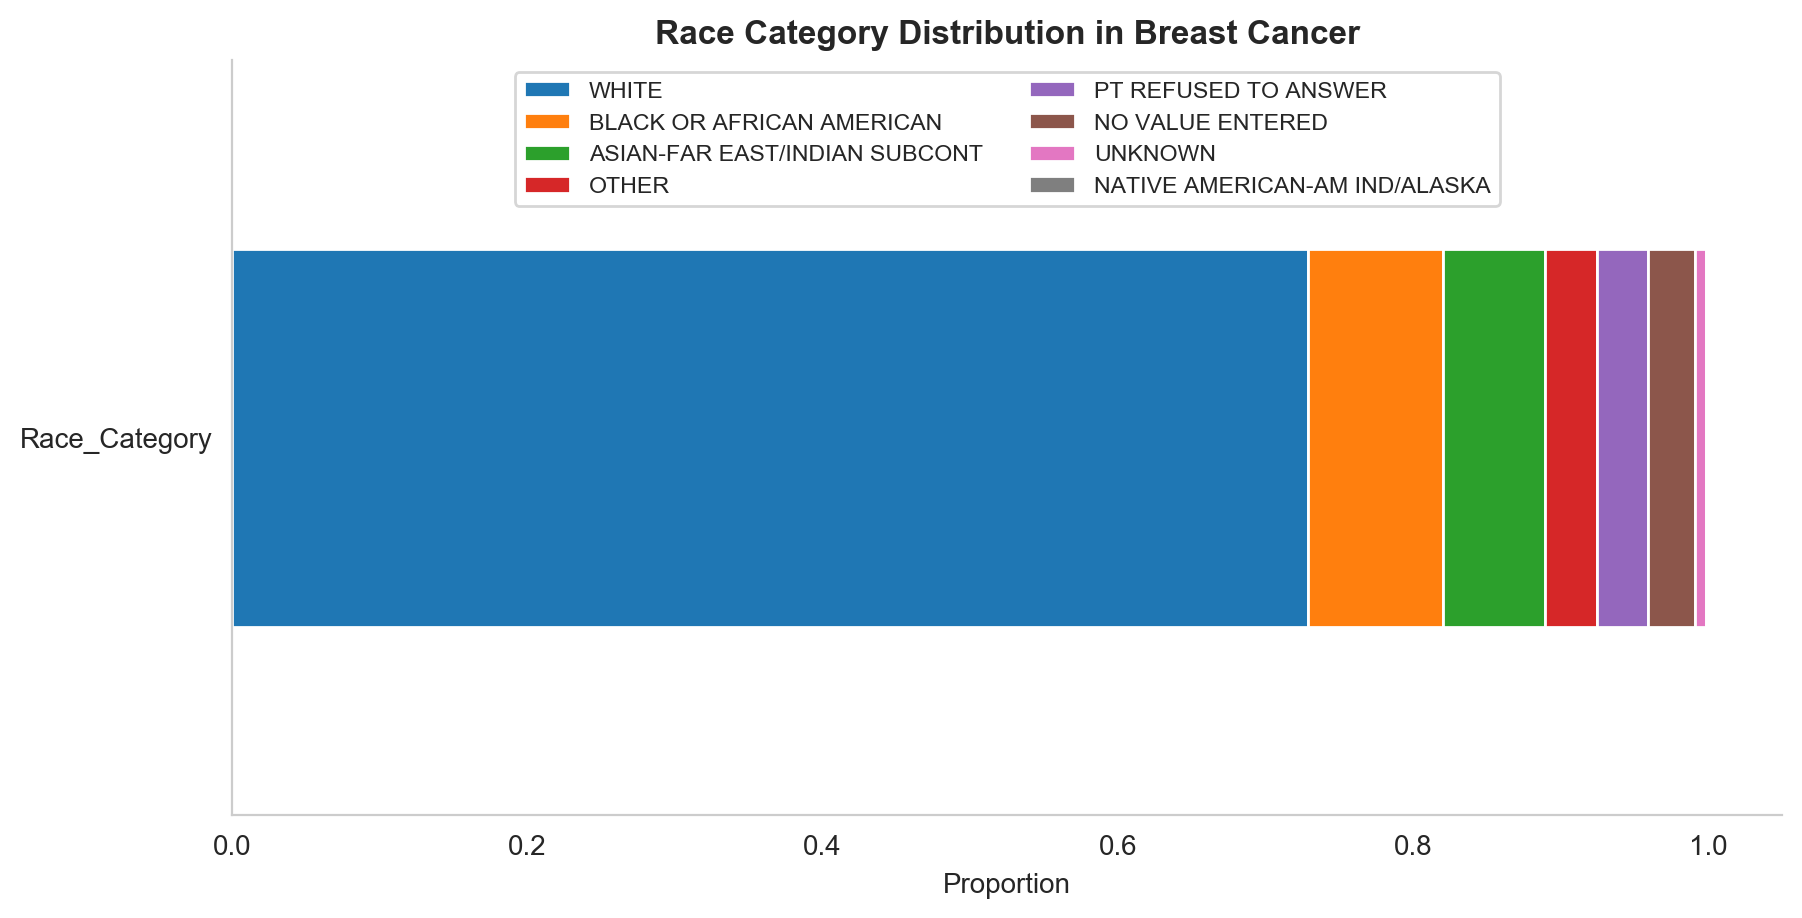

In [87]:
fig, ax = proportion_plot(master, 
                metrics='Race_Category',
                title= 'Overall Race Category Distribution in ',
                figsize=(10,5),
                display_table=True, 
                ncol_legend =2)

fig, ax = proportion_plot(master_cancer, 
                metrics='Race_Category',
                title= 'Race Category Distribution in ' + cancer_type,
                figsize=(10,5),
                display_table=True, 
                ncol_legend =2)

# Cancer Summary

In [44]:
plt.rc('text', usetex=False)

In [382]:
def plot_scatters(data: pd.DataFrame, title:str, metrics: str, ax, met_prim=False):
    data = data[data['tp53_count']>=2]
    if met_prim:
        data = data[data['Sample_Type'] == met_prim]
    data_ccf = data[[metrics + '_1', metrics + '_2',metrics + '_3',metrics + '_4',metrics + '_5']]
    max_table_ccf = pd.DataFrame(np.sort(data_ccf.fillna(0).values)[:,-2:], columns=['2nd-largest','largest'])
    max_table_ccf = pd.concat([max_table_ccf, data.reset_index().tp53_group], axis=1)
    
    sns.scatterplot(x='largest', y='2nd-largest', data=max_table_ccf, ax=ax, hue='tp53_group', palette=palette, legend=False, s=100)
    ax.plot([0,1], [0,1], linewidth=0.5, color='grey')
    ax.set_ylabel('')
    ax.set_xlabel('')
    for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14) 
    ax.set_title(title, weight = 'bold', fontsize=20)
    ax.text(.5,.9, str(data.shape[0]) +' samples',
        horizontalalignment='center',
        transform=ax.transAxes, fontsize=18)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
def boxplot_sampletype(df: pd.DataFrame, metrics: str, ax, title: str = '',tp53_metrics=False, title_font: int=20, xlim=[0,1], continuous= False):
    groupby = get_groupby(df, 'Sample_Type', 'count')

    if tp53_metrics:
        groupby= get_groupby(df[~df[metrics + '_1'].isna()], 'Sample_Type', 'count')
        data_1 =  pd.DataFrame(df[['Tumor_Id', metrics + '_1']])
        data_1.columns = ['Tumor_Id', metrics]
        data_2 = pd.DataFrame(df[['Tumor_Id', metrics + '_2']])
        data_2.columns = ['Tumor_Id', metrics]
        data_3 = pd.DataFrame(df[['Tumor_Id', metrics + '_3']])
        data_3.columns = ['Tumor_Id', metrics]
        data_4 = pd.DataFrame(df[['Tumor_Id', metrics + '_4']])
        data_4.columns = ['Tumor_Id', metrics]
        data_5 = pd.DataFrame(df[['Tumor_Id', metrics + '_5']])
        data_5.columns = ['Tumor_Id', metrics]
        data_tot = data_1.append(data_2)
        data_tot = data_tot.append(data_3)
        data_tot = data_tot.append(data_4)
        data_tot = data_tot.append(data_5)

        df = pd.merge(left=data_tot, right=df[['Tumor_Id','tp53_cn_state', 'tp53_tcn', 'Sample_Type']],how='left', left_on='Tumor_Id',right_on='Tumor_Id')
    
    if continuous == True:
        statistic, p_value = ranksums(df[df['Sample_Type'] == 'Primary'][metrics].dropna().values,df[df['Sample_Type'] == 'Metastasis'][metrics].dropna().values)
        if p_value<0.001: s='P < 0.001'
        else: s='P = %.3f'%p_value
        ax.annotate(s=s, xy=(0.9,0.5), xycoords='axes fraction', fontsize='x-large')
    
    else:
        statistic, p_value = ranksums(df[df['Sample_Type'] == 'Primary'][metrics].dropna().values,df[df['Sample_Type'] == 'Metastasis'][metrics].dropna().values)
        if p_value<0.001: s='P < 0.001'
        else: s='P = %.3f'%p_value
        ax.annotate(s=s, xy=(0.8,0.5), xycoords='axes fraction', fontsize='x-large')
    
    
    
    if continuous: sns.violinplot(x=metrics, y='Sample_Type',data=df,ax=ax, inner='quartile', dodge=False,order=['Primary', 'Metastasis'], palette='muted').set_title(title, weight='bold', fontsize=title_font)
    else: sns.boxplot(x=metrics, y='Sample_Type',data=df,ax=ax, dodge=False,order=['Primary', 'Metastasis'], palette='muted').set_title(title, weight='bold', fontsize=title_font)

    try:
        ax.set_yticklabels(['P (' + str(int(groupby.loc['Primary'])) + ')',
                            'M (' + str(int(groupby.loc['Metastasis'])) + ')'], 
                            fontsize=18)
    except: pass

    ax.set_xlim(xlim)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(14) 

'''def plot_mut_count_subgroups(df: pd.DataFrame, ax1, cancer_type: str, metrics: str, title: str = '',  xlim: int=25, met_prim = None, continuous=False, tp53_metrics=False, linewidth=1, width=1):
    
    # Figure initialization
    if met_prim:
        df = df[df['Sample_Type'] == met_prim]

    ax1.set_xlim(0, xlim)
    ax1.tick_params(axis='both', which='major', labelsize=8)

    my_colors = list(islice(cycle(list(sns.color_palette("muted"))), None, 6))
    my_colors_remixed = [my_colors[5], my_colors[2], my_colors[3], my_colors[0], my_colors[4], my_colors[1]]
    
    
    data = df
    data_cancer = data[data['Cancer_Type'] == cancer_type]

    if tp53_metrics:
        groupby= get_groupby(data_cancer[~df[metrics + '_1'].isna()], 'tp53_group', 'count')
        groupby = groupby.to_dict()['count']
        data_1 =  pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_1']])
        data_1.columns = ['Tumor_Id', metrics]
        data_2 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_2']])
        data_2.columns = ['Tumor_Id', metrics]
        data_3 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_3']])
        data_3.columns = ['Tumor_Id', metrics]
        data_4 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_4']])
        data_4.columns = ['Tumor_Id', metrics]
        data_5 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_5']])
        data_5.columns = ['Tumor_Id', metrics]
        data_tot = data_1.append(data_2)
        data_tot = data_tot.append(data_3)
        data_tot = data_tot.append(data_4)
        data_tot = data_tot.append(data_5)

        data_cancer = pd.merge(left=data_tot, right=data_cancer[['Tumor_Id','tp53_group', 'tp53_tcn', 'Sample_Type']],how='left', left_on='Tumor_Id',right_on='Tumor_Id')

    else:
        groupby = get_groupby(data_cancer, 'tp53_group', 'count') 
        groupby = groupby.to_dict()['count']
        
    for group in ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']:
        if group not in groupby: groupby[group] = 0

    if continuous:
        h=sns.violinplot(y="tp53_group",
                x=metrics,
                data=data_cancer,
                ax=ax1,
                dodge=False,
                inner='quartile',
                palette=my_colors_remixed,
                order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'],
                linewidth=linewidth, 
                width=width).set_title(title, weight='bold', fontsize=20)

    else:
        h=sns.boxplot(y="tp53_group",
                x=metrics,
                data=data_cancer,
                ax=ax1,
                dodge=False,
                palette=my_colors_remixed,
                order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']
                     ).set_title(title, weight='bold', fontsize=20)
    
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    try:
        ax1.set_yticklabels(['0_HETLOSS (' + str(int(groupby['0_HETLOSS'])) + ')',
                             '1_WILD_TYPE ('+ str(int(groupby['1_WILD_TYPE'])) + ')',
                             '>1muts ('+ str(int(groupby['>1muts'])) + ')',
                             '>=1_LOSS ('+ str(int(groupby['>=1_LOSS'])) + ')',
                             '>=1_cnLOH ('+ str(int(groupby['>=1_cnLOH'])) + ')',
                             'HOMDEL ('+ str(int(groupby['HOMDEL'])) + ')',
                              ], fontsize=18)
    except: pass
    
    style(ax1)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)'''

def plot_mut_count_subgroups(df: pd.DataFrame, ax1, cancer_type: str, metrics: str, title: str = '',  xlim: int=25, met_prim = None, continuous=False, tp53_metrics=False, linewidth=1, width=1, hue=False):
    
    # Figure initialization
    if met_prim:
        df = df[df['Sample_Type'] == met_prim]

    ax1.set_xlim(0, xlim)
    ax1.tick_params(axis='both', which='major', labelsize=8)

    my_colors = list(islice(cycle(list(sns.color_palette("muted"))), None, 6))
    my_colors_remixed = [my_colors[5], my_colors[2], my_colors[3], my_colors[0], my_colors[4], my_colors[1]]
    my_colors_remixed_hue = [my_colors[5],my_colors[5], my_colors[2], my_colors[2],my_colors[3], my_colors[3],
                             my_colors[0],my_colors[0], my_colors[4],my_colors[4], my_colors[1], my_colors[1]]
    
    
    data = df
    data_cancer = data[data['Cancer_Type'] == cancer_type]

    if tp53_metrics:
        groupby= get_groupby(data_cancer[~data_cancer[metrics + '_1'].isna()], 'tp53_group', 'count')
        groupby_prim = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Primary'][~data_cancer[metrics + '_1'].isna()], 'tp53_group', 'count') 
        groupby_met = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Metastasis'][~data_cancer[metrics + '_1'].isna()], 'tp53_group', 'count')
        groupby = groupby.to_dict()['count'] ; groupby_prim = groupby_prim.to_dict()['count'] ; groupby_met = groupby_met.to_dict()['count']
        data_1 =  pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_1']])
        data_1.columns = ['Tumor_Id', metrics]
        data_2 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_2']])
        data_2.columns = ['Tumor_Id', metrics]
        data_3 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_3']])
        data_3.columns = ['Tumor_Id', metrics]
        data_4 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_4']])
        data_4.columns = ['Tumor_Id', metrics]
        data_5 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_5']])
        data_5.columns = ['Tumor_Id', metrics]
        data_tot = data_1.append(data_2)
        data_tot = data_tot.append(data_3)
        data_tot = data_tot.append(data_4)
        data_tot = data_tot.append(data_5)

        data_cancer = pd.merge(left=data_tot, right=data_cancer[['Tumor_Id','tp53_group', 'tp53_tcn', 'Sample_Type']],how='left', left_on='Tumor_Id',right_on='Tumor_Id')

    else:
        groupby = get_groupby(data_cancer, 'tp53_group', 'count') 
        groupby_prim = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Primary'], 'tp53_group', 'count') 
        groupby_met = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Metastasis'], 'tp53_group', 'count')
        groupby = groupby.to_dict()['count'] ; groupby_prim = groupby_prim.to_dict()['count'] ; groupby_met = groupby_met.to_dict()['count']
    
    for groupbys in [groupby, groupby_prim, groupby_met]:
        for group in ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']:
            if group not in groupbys: groupbys[group] = 0

    if continuous:
        if hue == True: 
            h=sns.violinplot(y="tp53_group",
                    x=metrics,
                    data=data_cancer,
                    ax=ax1,
                    dodge=False,
                    hue='Sample_Type',
                    split=True,
                    cut=0,
                    inner="quartile",
                    palette=['darkviolet', 'lightpink'],
                    order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'],
                    linewidth=linewidth, 
                    width=width,
                    legend_out=False)
            #patch_violinplot(my_colors_remixed_hue, ax1, groupby_met, groupby_prim)
        else:
            h=sns.violinplot(y="tp53_group",
                    x=metrics,
                    data=data_cancer,
                    ax=ax1,
                    dodge=False,
                    split=True,
                    inner="quartile",
                    palette=my_colors_remixed,
                    order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'],
                    linewidth=linewidth, 
                    width=width).set_title(title, weight='bold', fontsize=20)

    else:
        if hue==True:
            h=sns.boxplot(y="tp53_group",
                    x=metrics,
                    data=data_cancer,
                    ax=ax1,
                    dodge=True,
                    hue='Sample_Type',
                    palette=['darkviolet', 'lightpink'],
                    order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'])
            
        else:
            h=sns.boxplot(y="tp53_group",
                    x=metrics,
                    data=data_cancer,
                    ax=ax1,
                    dodge=False,
                    palette=my_colors_remixed,
                    order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']
                         ).set_title(title, weight='bold', fontsize=20)

    ax1.set_xlabel('')
    ax1.set_ylabel('')
    if hue:
        ax1.set_yticklabels(['0_HETLOSS: P ' + str(int(groupby_prim['0_HETLOSS'])) + '\nM '+str(int(groupby_met['0_HETLOSS'])),
                             '1_WILD_TYPE: P '+ str(int(groupby['1_WILD_TYPE']))+ '\nM '+str(int(groupby_met['1_WILD_TYPE'])),
                             '>1muts: P '+ str(int(groupby['>1muts']))+ '\nM '+str(int(groupby_met['>1muts'])),
                             '>=1_LOSS: P '+ str(int(groupby['>=1_LOSS']))+ '\nM '+str(int(groupby_met['>=1_LOSS'])),
                             '>=1_cnLOH: P '+ str(int(groupby['>=1_cnLOH']))+ '\nM '+str(int(groupby_met['>=1_cnLOH'])),
                             'HOMDEL: P '+ str(int(groupby['HOMDEL']))+ '\nM '+str(int(groupby_met['HOMDEL'])),
                              ], fontsize=18)
        ax1.legend_.remove()
        ax1.set_title(title, weight='bold', fontsize=20)
            
    
    else:   
        try:
            ax1.set_yticklabels(['0_HETLOSS (' + str(int(groupby['0_HETLOSS'])) + ')',
                                 '1_WILD_TYPE ('+ str(int(groupby['1_WILD_TYPE'])) + ')',
                                 '>1muts ('+ str(int(groupby['>1muts'])) + ')',
                                 '>=1_LOSS ('+ str(int(groupby['>=1_LOSS'])) + ')\n123',
                                 '>=1_cnLOH ('+ str(int(groupby['>=1_cnLOH'])) + ')',
                                 'HOMDEL ('+ str(int(groupby['HOMDEL'])) + ')',
                                  ], fontsize=18)
        except: pass
    
    # Add significance
    
    for i,group in enumerate(['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']):
        master_group = data_cancer[data_cancer['tp53_group'] == group]
        statistic, p_value = ranksums(master_group[master_group['Sample_Type'] == 'Primary'][metrics].dropna().values,master_group[master_group['Sample_Type'] == 'Metastasis'][metrics].dropna().values)
        #print(p_value)
        if p_value<0.001:
            s='P<0.001'
        else:
            s='P=%.3f'%p_value
        if continuous == True:
            ax1.annotate(s=s, xy=(0,0.97 - (1/6)*i), xycoords='axes fraction', fontsize=14)
        else:
            ax1.annotate(s=s, xy=(0.8,0.9 - (1/6)*i), xycoords='axes fraction', fontsize=14)
    
    
    style(ax1)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(14) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(14)
   

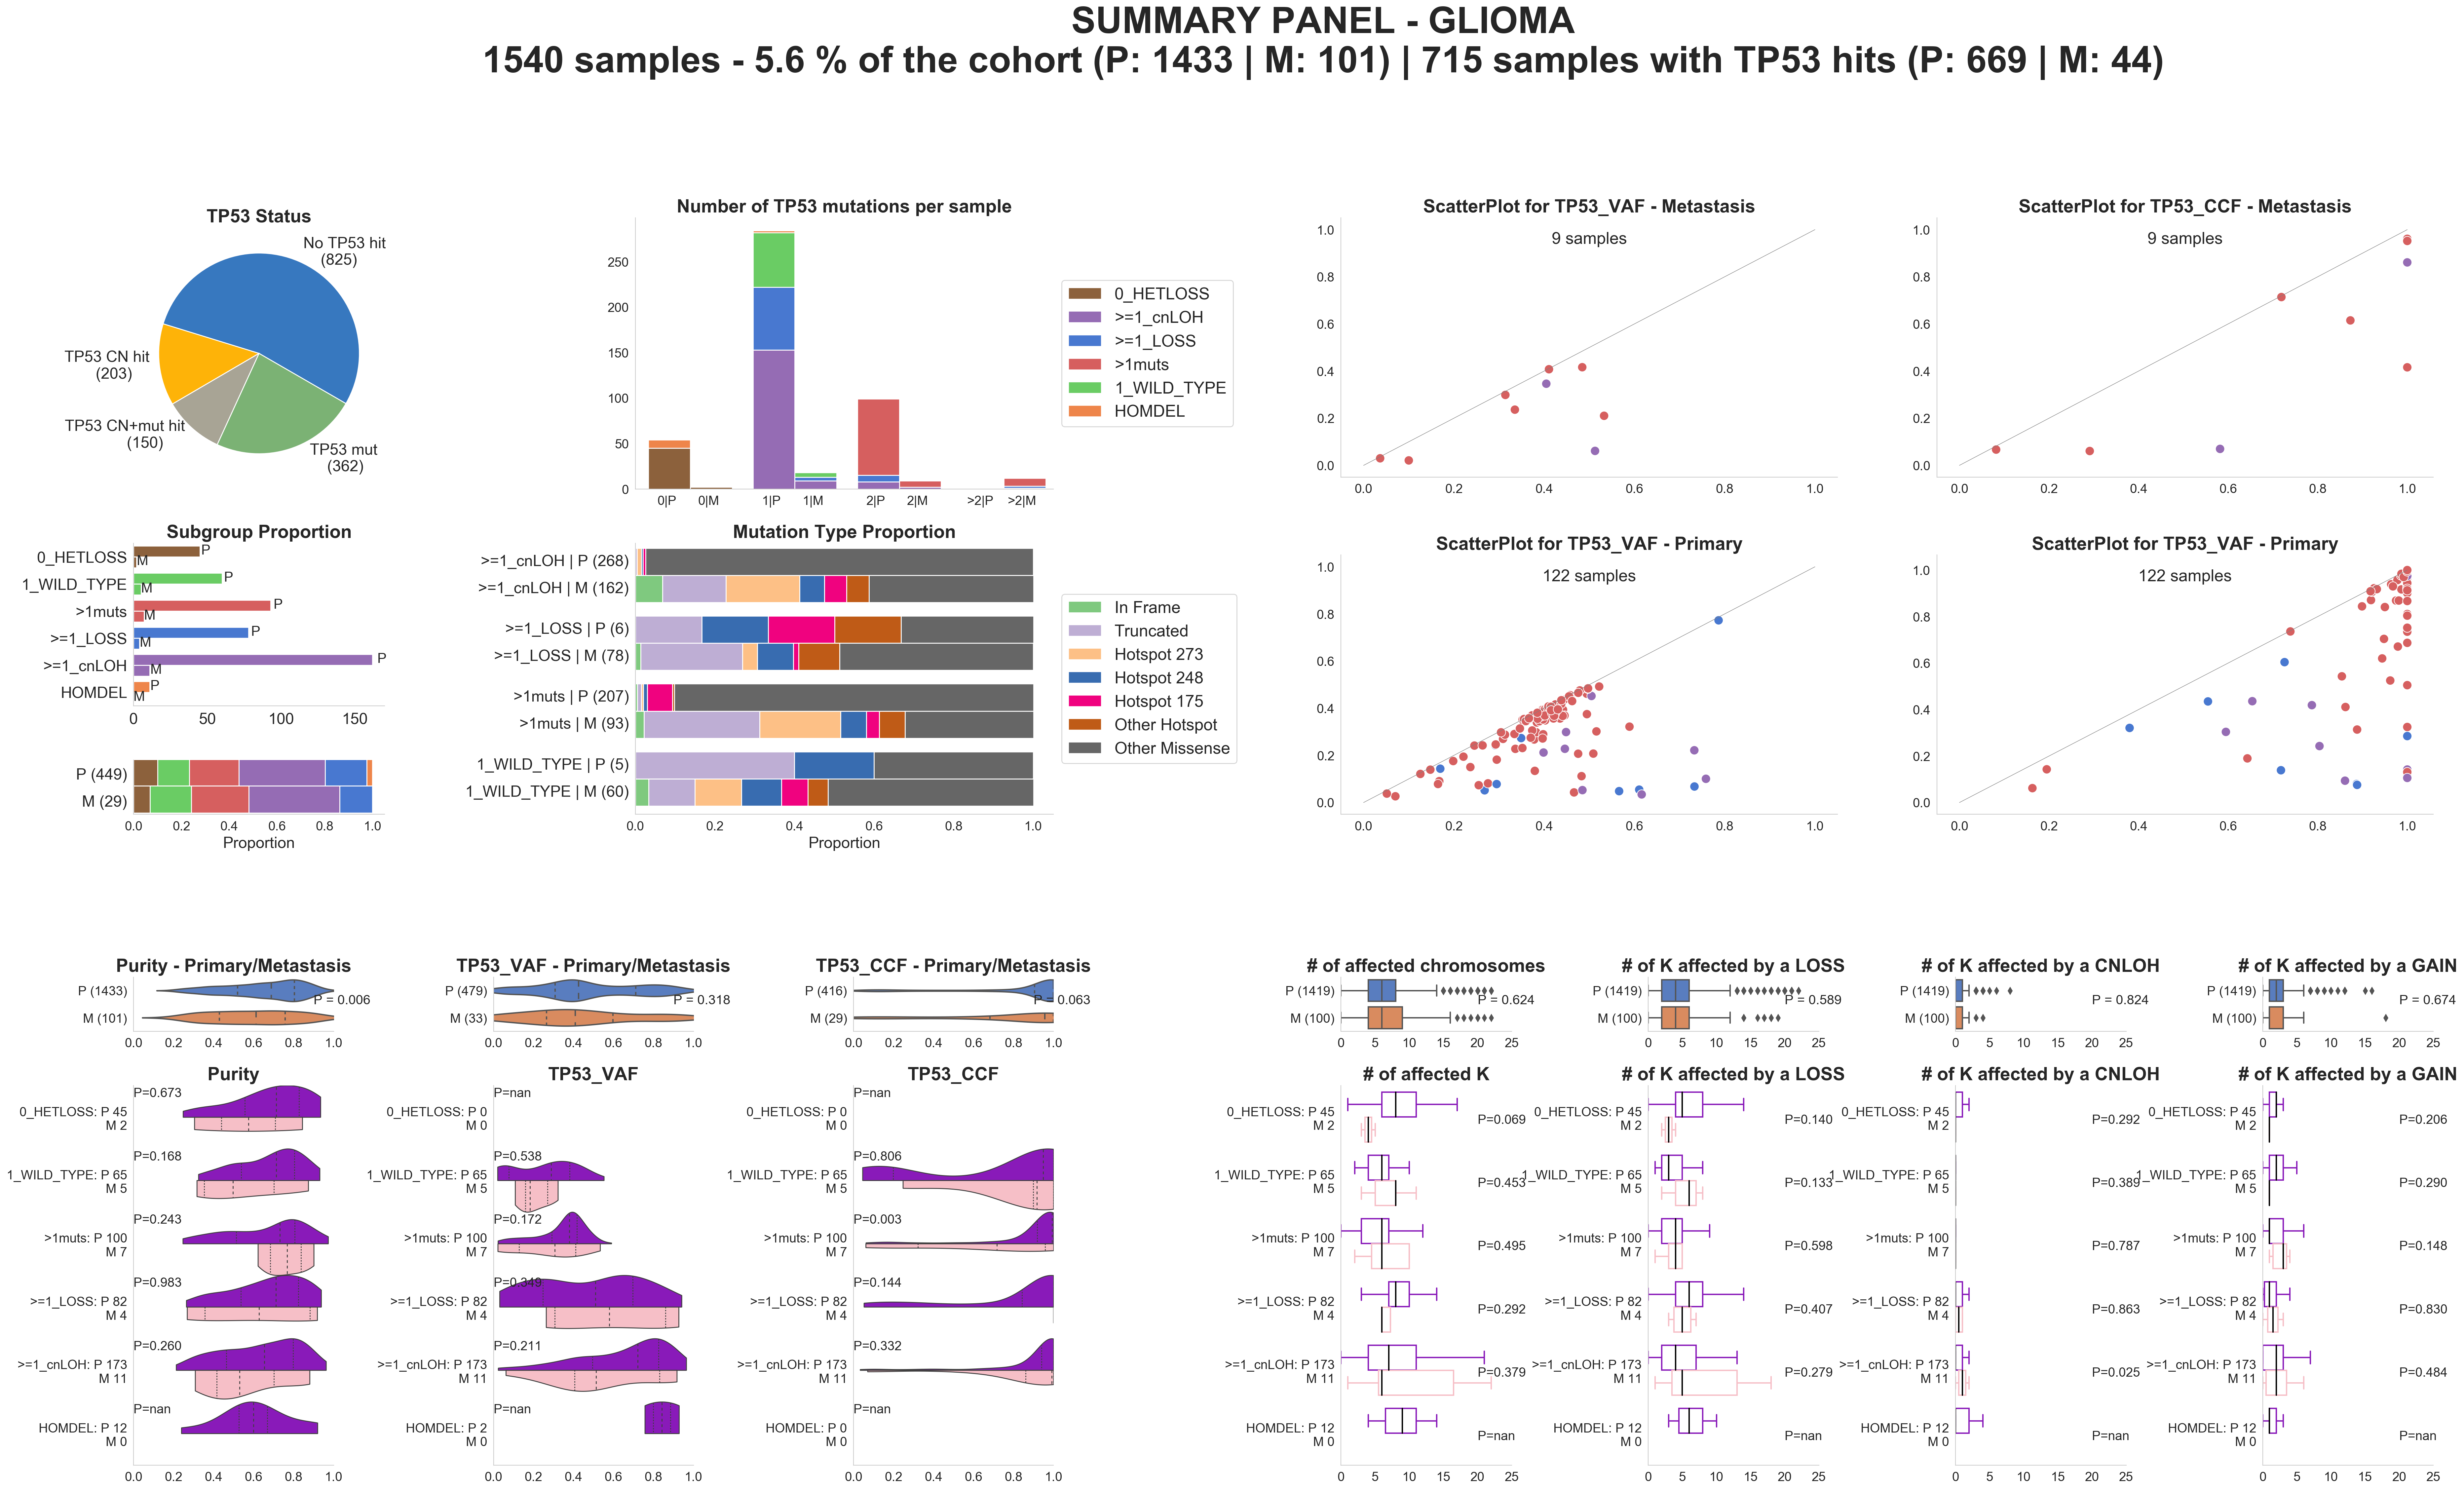

In [383]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(40,40))
outer = gridspec.GridSpec(nrows=20, ncols=14)

##==================================================================================================================
# PIE CHART + Prim/Met + # of muts + mutation_type

inner = gridspec.GridSpecFromSubplotSpec(nrows=6, ncols=6, subplot_spec=outer[0:6  , :6],wspace=1, hspace=1)
ax_inner_pie = plt.Subplot(fig, inner[:3,:2])
ax_inner_sampletype = plt.Subplot(fig, inner[3:5,:2])
ax_inner_subgroup = plt.Subplot(fig, inner[5:6,:2])
ax_inner_muttype = plt.Subplot(fig, inner[3:6,3:6])
ax_inner_num_mut = plt.Subplot(fig, inner[:3,3:6])


# PIE
sizes = [master_cancer.shape[0] - master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] == 'DIPLOID'].shape[0] - master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0] - master_cancer[master_cancer['tp53_count'] ==0][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0], 
        master_cancer[master_cancer['tp53_count'] ==0][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0],
        master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] == 'DIPLOID'].shape[0],
        master_cancer[master_cancer['tp53_count'] >=1][master_cancer['tp53_cn_state'] != 'DIPLOID'].shape[0]  
        ]

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]

labels = ['No TP53 hit\n    (' + str(sizes[0])+')', 'TP53 CN hit\n     ('+str(sizes[1])+')    ', 'TP53 CN+mut hit\n     ('+str(sizes[2])+')     ',  '    TP53 mut  \n        ('+str(sizes[3])+')     ']
patches, texts = ax_inner_pie.pie(sizes, labels=labels, startangle=330, colors=sns.xkcd_palette(colors))
texts = [ _.set_fontsize(17) for _ in texts ]
ax_inner_pie.set_title('TP53 Status', weight='bold', fontsize=20)

fig.add_subplot(ax_inner_pie)

# Subgroup Proportion (Numbers)
ax_inner_sampletype.set_title('Subgroup Proportion', fontsize=20, weight='bold')
g = sns.countplot(data=master_cancer, y='tp53_group', ax=ax_inner_sampletype, hue='Sample_Type',
                  order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'])
ax_inner_sampletype.spines['right'].set_visible(False)
ax_inner_sampletype.spines['top'].set_visible(False)
ax_inner_sampletype.set_xlabel('')
ax_inner_sampletype.set_ylabel('')
ax_inner_sampletype.xaxis.set_tick_params(labelsize=17)
ax_inner_sampletype.yaxis.set_tick_params(labelsize=17)
ax_inner_sampletype.get_legend().remove()

rects = ax_inner_sampletype.patches
labels = ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']*2
met_prim = ['P']*6 + ['M']*6
for rect, label, i in zip(rects, labels, range(12)):
    height = rect.get_height()
    width = rect.get_width()
    width = rect.get_width()
    if np.isnan(width) : width = 0
    ax_inner_sampletype.text(width*(102/100) , rect.get_y()+height,  str(met_prim[i]),
        ha='left', va='bottom', fontsize=15)
    rect.set_facecolor(palette[label])
    
fig.add_subplot(ax_inner_sampletype)


# Subgroup Proportion [0,1]
metrics='tp53_group'
count_prim = get_groupby(master_cancer[master_cancer['Sample_Type'] == 'Primary'], metrics, 'count_prim_' + metrics)
count_met = get_groupby(master_cancer[master_cancer['Sample_Type'] == 'Metastasis'], metrics, 'count_met_' + metrics)
freq_prim = pd.DataFrame(count_prim['count_prim_' + metrics]).sort_values(by=['count_prim_' + metrics], ascending=False)/ pd.DataFrame(count_prim['count_prim_' + metrics]).sum()
freq_met = pd.DataFrame(count_met['count_met_' + metrics]).sort_values(by=['count_met_' + metrics], ascending=False)/ pd.DataFrame(count_met['count_met_' + metrics]).sum()
freq_prim.columns=['P'] ; freq_met.columns=['M']
freq = pd.concat([freq_met, freq_prim], axis=1)
freq = freq.reindex(group_list)

h = freq.T.plot(kind = 'barh', stacked=True, ax=ax_inner_subgroup, yticks=[], color=palette_list)
ax_inner_subgroup.legend_.remove()
ax_inner_subgroup.yaxis.set_major_formatter(matplotlib.ticker.IndexFormatter(['M (' + str(pd.DataFrame(count_met['count_met_' + metrics]).sum().values[0])+')', 'P (' + str(pd.DataFrame(count_prim['count_prim_' + metrics]).sum().values[0])+')']))
ax_inner_subgroup.set_xlabel('Proportion', fontsize=17)
ax_inner_subgroup.spines['right'].set_visible(False)
ax_inner_subgroup.spines['top'].set_visible(False)
for tick in ax_inner_subgroup.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax_inner_subgroup.yaxis.get_major_ticks():
    tick.label.set_fontsize(17) 
    
for container in ax_inner_subgroup.containers:
    for i, child in enumerate(container.get_children()):
        child.set_y(child.get_y() - 0.2)
        child.set_height(1)
    
fig.add_subplot(ax_inner_subgroup)


# # of Muts
groups = ['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL']

for i,group in enumerate(groups):
    master_group = master_cancer[master_cancer['tp53_group'] == group]#[master_cancer['tp53_count']<4]
    groupby_prim = get_groupby(master_group[master_group['Sample_Type'] == 'Primary'], 'tp53_count', group + '_count')
    groupby_met = get_groupby(master_group[master_group['Sample_Type'] == 'Metastasis'], 'tp53_count', group + '_count')
    if i == 0 : met = groupby_met ; prim = groupby_prim
    else: met = pd.concat([met, groupby_met], axis=1) ; prim = pd.concat([prim, groupby_prim], axis=1)
for i in [0,1,2,3,4,5]:
    if i not in met.index: met.loc[i]=[0]*6
    if i not in prim.index: prim.loc[i]=[0]*6   
met = met.fillna(0) ; prim = prim.fillna(0)
met.index = ['0 | M', '1 | M', '2 | M', '3 | M', '4 | M', '5 | M'] ; prim.index = ['0 | P', '1 | P', '2 | P', '3 | P', '4 | P', '5 | P']
count = pd.concat([met, prim], axis=0)
count= count.fillna(0)
count = count.reindex(['0 | P', '0 | M','1 | P','1 | M','2 | P','2 | M','3 | P','3 | M', '4 | P', '4 | M', '5 | P', '5 | M'])
count.loc['>2 | M'] = count.apply(lambda x: x['3 | M'] + x['4 | M'] + x['5 | M'], axis=0)
count.loc['>2 | P'] = count.apply(lambda x: x['3 | P'] + x['4 | P'] + x['5 | P'], axis=0)
count = count.drop(['3 | P','3 | M', '4 | P', '4 | M', '5 | P', '5 | M'])

h = count.plot(kind = 'bar', stacked=True, ax=ax_inner_num_mut)
h.set_xticklabels(['0|P', '0|M','1|P','1|M','2|P','2|M','>2|P','>2|M'], rotation=0)

# Put a legend to the right of the current axis
ax_inner_num_mut.set_title('Number of TP53 mutations per sample',weight='bold', fontsize=20)
ax_inner_num_mut.spines['right'].set_visible(False)
ax_inner_num_mut.spines['top'].set_visible(False)
ax_inner_num_mut.grid(True)

palette_list_new = [mc[5],mc[4],mc[0],mc[3],mc[2], mc[1]]
for j,container in enumerate(ax_inner_num_mut.containers):
    for i, child in enumerate(container.get_children()):
        child.set_facecolor(palette_list_new[j])
        if i%2 == 1: child.set_x(child.get_x() - 0.2)
        child.set_width(0.8)
        
ax_inner_num_mut.set_xticks([0.1, 0.9, 2.1, 2.9, 4.1, 4.9, 6.1, 6.9])

# Shrink current axis by 20%
box = ax_inner_num_mut.get_position()
ax_inner_num_mut.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax_inner_num_mut.legend(['0_HETLOSS', '>=1_cnLOH', '>=1_LOSS', '>1muts', '1_WILD_TYPE','HOMDEL'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)

for tick in ax_inner_num_mut.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax_inner_num_mut.yaxis.get_major_ticks():
    tick.label.set_fontsize(14) 



fig.add_subplot(ax_inner_num_mut)


# Mutation Type

mut_subgroups = ['>=1_LOSS', '>=1_cnLOH', '1_WILD_TYPE', 'HOMDEL', '>1muts']
for subgroup in mut_subgroups:
    data_prim = master_cancer[master_cancer['tp53_group'] == subgroup][master_cancer['Sample_Type'] == 'Primary']
    data_met = master_cancer[master_cancer['tp53_group'] == subgroup][master_cancer['Sample_Type'] == 'Metastasis']
    data_1m = get_groupby(data_prim,'tp53_vc_group_1', 'count'); data_2p = get_groupby(data_prim,'tp53_vc_group_2', 'count'); data_3p = get_groupby(data_prim,'tp53_vc_group_3', 'count') ; data_4p = get_groupby(data_prim,'tp53_vc_group_4', 'count') ; data_5p = get_groupby(data_prim,'tp53_vc_group_5', 'count') 
    data_1p = get_groupby(data_met,'tp53_vc_group_1', 'count'); data_2m = get_groupby(data_met,'tp53_vc_group_2', 'count'); data_3m = get_groupby(data_met,'tp53_vc_group_3', 'count') ; data_4m = get_groupby(data_met,'tp53_vc_group_4', 'count') ; data_5m = get_groupby(data_met,'tp53_vc_group_5', 'count') 
    count_m = (data_1m+data_2m+data_3m+data_4m+data_5m).fillna(data_1m).fillna(data_2m).fillna(data_3m).fillna(data_4m).fillna(data_5m).sort_values(by=['count'])
    count_p = (data_1p+data_2p+data_3p+data_4p+data_5p).fillna(data_1p).fillna(data_2p).fillna(data_3p).fillna(data_4p).fillna(data_5p).sort_values(by=['count'])
    count_m.columns=[subgroup] ; count_p.columns=[subgroup]
    if subgroup == '>=1_LOSS': countm = count_m ; countp = count_p
        
    else: countm = pd.concat([countm, count_m], axis=1) ; countp = pd.concat([countp, count_p], axis=1)
        
countm = countm.T.fillna(0) ; countp = countp.T.fillna(0)

columns_m = list(countm.columns)
columns_p = list(countm.columns)


for column in columns_m:
    countm[column + '_r'] = countm.apply(lambda x: round(x[column]/x[columns_m].sum(),3), axis=1)
for column in columns_p:   
    countp[column + '_r'] = countp.apply(lambda x: round(x[column]/x[columns_m].sum(),3), axis=1)
countp['sum_p'] = countp[columns_p].sum(axis=1) ; countm['sum_m'] = countm[columns_m].sum(axis=1)
countm = countm.set_index(pd.Series(['>=1_LOSS | M', '>=1_cnLOH | M', '1_WILD_TYPE | M', 'HOMDEL | M', '>1muts | M']))
countp = countp.set_index(pd.Series(['>=1_LOSS | P', '>=1_cnLOH | P', '1_WILD_TYPE | P', 'HOMDEL | P', '>1muts | P']))

count = pd.concat([countp, countm], axis=0).fillna(0)
count = count.reindex(['1_WILD_TYPE | P','1_WILD_TYPE | M', '>1muts | P', '>1muts | M'
                       ,'>=1_LOSS | P','>=1_LOSS | M', '>=1_cnLOH | P', '>=1_cnLOH | M',
                        'HOMDEL | P','HOMDEL | M'])

count = count.drop(['HOMDEL | P', 'HOMDEL | M'])

df = count[['in_frame_r','truncated_r', '273_r', '248_r', '175_r','hotspot_r', 'missense_r']]
h = df.plot(kind = 'barh', stacked=True, ax=ax_inner_muttype, yticks=[], colormap="Accent")
ax_inner_muttype.legend(fontsize='small', ncol=1)
ax_inner_muttype.set_xlabel('Proportion', fontsize=17)

ax_inner_muttype.spines['right'].set_visible(False)
ax_inner_muttype.spines['top'].set_visible(False)
ax_inner_muttype.set_ylabel('')

# Shrink current axis by 20%
box = ax_inner_muttype.get_position()
ax_inner_muttype.set_position([box.x0, box.y0, box.width * 0.8, box.height])
# Put a legend to the right of the current axis
ax_inner_muttype.legend(['In Frame', 'Truncated', 'Hotspot 273','Hotspot 248','Hotspot 175', 'Other Hotspot', 'Other Missense'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=18)
ax_inner_muttype.set_title('Mutation Type Proportion',weight='bold', fontsize=20)


for container in ax_inner_muttype.containers:
    for i, child in enumerate(container.get_children()):
        child.set_height(0.8)
        if i%2 == 1:
            child.set_y(child.get_y() - 0.2)
            
            
for container in ax_inner_muttype.containers:
    for i, child in enumerate(container.get_children()):
        if i%2 == 1: child.set_y(child.get_y() - child.get_height())  
        if i%2 == 0: child.set_y(child.get_y() + child.get_height())


try:
        ax_inner_muttype.set_yticklabels(['1_WILD_TYPE | P ('+ str(int(count.loc['1_WILD_TYPE | P', 'sum_p'])) + ')',
                            '1_WILD_TYPE | M ('+ str(int(count.loc['1_WILD_TYPE | M', 'sum_m'])) + ')',
                            '>1muts | P ('+ str(int(count.loc['>1muts | P', 'sum_p'])) + ')',
                            '>1muts | M ('+ str(int(count.loc['>1muts | M', 'sum_m'])) + ')',
                            '>=1_LOSS | P ('+ str(int(count.loc['>=1_LOSS | P', 'sum_p'])) + ')',
                            '>=1_LOSS | M ('+ str(int(count.loc['>=1_LOSS | M', 'sum_m'])) + ')',
                            '>=1_cnLOH | P ('+ str(int(count.loc['>=1_cnLOH | P', 'sum_p'])) + ')',
                            '>=1_cnLOH | M ('+ str(int(count.loc['>=1_cnLOH | M', 'sum_m'])) + ')'],
                             fontsize=10)
except: pass

ax_inner_muttype.set_yticks([1, 0.2, 3,2.2, 5, 4.2, 7, 6.2])
for tick in ax_inner_muttype.xaxis.get_major_ticks():
    tick.label.set_fontsize(14) 
for tick in ax_inner_muttype.yaxis.get_major_ticks():
    tick.label.set_fontsize(17)


fig.add_subplot(ax_inner_muttype)

##==================================================================================================================
# ScatterPlots

inner = gridspec.GridSpecFromSubplotSpec(nrows=2, ncols=2, subplot_spec=outer[0:6  , 7:14],wspace=0.2, hspace=0.3)
ax_inner_vafm = plt.Subplot(fig, inner[0,0])
ax_inner_vafp = plt.Subplot(fig, inner[1,0])
ax_inner_ccfm = plt.Subplot(fig, inner[0,1])
ax_inner_ccfp = plt.Subplot(fig, inner[1,1])

plot_scatters(master_cancer, 
              title='ScatterPlot for TP53_VAF - Metastasis', 
              metrics='tp53_vaf', 
              met_prim='Metastasis',
              ax=ax_inner_vafm)
plot_scatters(master_cancer, 
              title='ScatterPlot for TP53_VAF - Primary', 
              metrics='tp53_vaf', 
              met_prim='Primary',
              ax=ax_inner_vafp)
plot_scatters(master_cancer, 
              title='ScatterPlot for TP53_CCF - Metastasis', 
              metrics='tp53_ccf', 
              met_prim='Metastasis',
              ax=ax_inner_ccfm)
plot_scatters(master_cancer, 
              title='ScatterPlot for TP53_VAF - Primary', 
              metrics='tp53_ccf', 
              met_prim='Primary',
              ax=ax_inner_ccfp)


fig.add_subplot(ax_inner_vafp)
fig.add_subplot(ax_inner_vafm)
fig.add_subplot(ax_inner_ccfp)
fig.add_subplot(ax_inner_ccfm)


##==================================================================================================================
# Purity / tp53_vaf / tp53_ccf MET vs PRIM

inner = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=3, subplot_spec=outer[7:8, :6],wspace=0.8, hspace=3)
ax_inner_pur = plt.Subplot(fig, inner[0,0])
ax_inner_vaf = plt.Subplot(fig, inner[0,1])
ax_inner_ccf = plt.Subplot(fig, inner[0,2])

boxplot_sampletype(master_cancer,
                 'purity',
                 title='Purity - Primary/Metastasis', 
                 ax=ax_inner_pur,
                 title_font=20,
                continuous=True)

boxplot_sampletype(master_cancer,
                 'tp53_vaf',
                 title='TP53_VAF - Primary/Metastasis',
                 ax=ax_inner_vaf,
                 tp53_metrics=True,
                 title_font=20,
                 continuous=True)

boxplot_sampletype(master_cancer,
                 'tp53_ccf',
                 title='TP53_CCF - Primary/Metastasis', 
                 title_font=20,
                 ax=ax_inner_ccf,
                 tp53_metrics= True,
                 continuous=True)

fig.add_subplot(ax_inner_pur)
fig.add_subplot(ax_inner_vaf)
fig.add_subplot(ax_inner_ccf)

##==================================================================================================================
# Purity / tp53_vaf / tp53_ccf met/prim Subgroups

inner_bis = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=3, subplot_spec=outer[8:12, :6],wspace=0.8, hspace=0)
ax_inner_pursub = plt.Subplot(fig, inner_bis[0,0])
ax_inner_vafsub = plt.Subplot(fig, inner_bis[0,1])
ax_inner_ccfsub = plt.Subplot(fig, inner_bis[0,2])

plot_mut_count_subgroups(master_cancer,
                         ax1=ax_inner_pursub,
                         cancer_type=cancer_type, 
                         metrics='purity', 
                         title= 'Purity', 
                         xlim=1, 
                         met_prim = None,
                         hue=True,
                         continuous=True,
                         linewidth=1)

plot_mut_count_subgroups(master_cancer, 
                         ax1=ax_inner_vafsub,
                         cancer_type=cancer_type, 
                         metrics='tp53_vaf', 
                         title= 'TP53_VAF', 
                         xlim=1, 
                         met_prim = None,
                         tp53_metrics=True,
                         hue=True,
                         continuous=True,
                         linewidth=1)

plot_mut_count_subgroups(master_cancer, 
                         ax1=ax_inner_ccfsub,
                         cancer_type=cancer_type, 
                         metrics='tp53_ccf', 
                         title= 'TP53_CCF', 
                         xlim=1, 
                         met_prim = None,
                         hue=True,
                         tp53_metrics=True,
                         continuous=True,
                         linewidth=1)

fig.add_subplot(ax_inner_pursub)
fig.add_subplot(ax_inner_vafsub)
fig.add_subplot(ax_inner_ccfsub)

##==================================================================================================================
# chr_affected / chr_loss / chr_cnloh / chr_gain met VS prim

inner_ter = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=4, subplot_spec=outer[7:8, 7:14],wspace=0.8, hspace=0)
ax_inner_aff = plt.Subplot(fig, inner_ter[0])
ax_inner_loss = plt.Subplot(fig, inner_ter[1])
ax_inner_cnloh = plt.Subplot(fig, inner_ter[2])
ax_inner_gain = plt.Subplot(fig, inner_ter[3])

master_cancer_gi = master_cancer[master_cancer['chr_affected']!='NaN']

boxplot_sampletype(master_cancer_gi,
                 'chr_affected',
                 title='# of affected chromosomes', 
                 ax=ax_inner_aff,
                 title_font=20,
                 xlim=[0,25],
                continuous=False)

boxplot_sampletype(master_cancer_gi,
                 'chr_loss',
                 title='# of K affected by a LOSS',
                 ax=ax_inner_loss,
                 tp53_metrics=False,
                 title_font=20,
                 xlim=[0,25],
                 continuous=False)

boxplot_sampletype(master_cancer_gi,
                 'chr_cnloh',
                 title='# of K affected by a CNLOH', 
                 title_font=20,
                 ax=ax_inner_cnloh,
                 tp53_metrics= False,
                 xlim=[0,25],
                 continuous=False)

boxplot_sampletype(master_cancer_gi,
                 'chr_gain',
                 title='# of K affected by a GAIN', 
                 title_font=20,
                 ax=ax_inner_gain,
                 tp53_metrics= False,
                 xlim=[0,25],
                 continuous=False)


fig.add_subplot(ax_inner_aff)
fig.add_subplot(ax_inner_loss)
fig.add_subplot(ax_inner_cnloh)
fig.add_subplot(ax_inner_gain)


##==================================================================================================================
# chr_affected / chr_loss / chr_cnloh / chr_gain subgroups

inner_4 = gridspec.GridSpecFromSubplotSpec(nrows=1, ncols=4, subplot_spec=outer[8:12, 7:14],wspace=0.8, hspace=0)
ax_inner_aff = plt.Subplot(fig, inner_4[0])
ax_inner_loss = plt.Subplot(fig, inner_4[1])
ax_inner_cnloh = plt.Subplot(fig, inner_4[2])
ax_inner_gain = plt.Subplot(fig, inner_4[3])

plot_mut_count_subgroups(master_cancer_gi,
                         ax1=ax_inner_aff,
                         cancer_type=cancer_type, 
                         metrics='chr_affected', 
                         title= '# of affected K', 
                         xlim=25, 
                         met_prim = None,
                         hue=True,
                         continuous=False)

plot_mut_count_subgroups(master_cancer_gi,
                         ax1=ax_inner_loss,
                         cancer_type=cancer_type, 
                         metrics='chr_loss', 
                         title= '# of K affected by a LOSS', 
                         xlim=25, 
                         met_prim = None,
                         hue=True,
                         continuous=False)

plot_mut_count_subgroups(master_cancer_gi,
                         ax1=ax_inner_cnloh,
                         cancer_type=cancer_type, 
                         metrics='chr_cnloh', 
                         title= '# of K affected by a CNLOH', 
                         xlim=25, 
                         met_prim = None,
                         hue=True,
                         continuous=False)
plot_mut_count_subgroups(master_cancer_gi,
                         ax1=ax_inner_gain,
                         cancer_type=cancer_type, 
                         metrics='chr_gain', 
                         title= '# of K affected by a GAIN', 
                         xlim=25, 
                         met_prim = None,
                         hue=True,
                         continuous=False)

fig.add_subplot(ax_inner_aff)
fig.add_subplot(ax_inner_loss)
fig.add_subplot(ax_inner_cnloh)
fig.add_subplot(ax_inner_gain)



fig.subplots_adjust(left=0.05, bottom=0.10, right=0.92, top=0.90, wspace=2, hspace=1)
            
fig.suptitle('SUMMARY PANEL - ' + cancer_type.upper() + 
             '\n' + '{} samples - {} % of the cohort (P: {} | M: {}) | {} samples with TP53 hits (P: {} | M: {})'.format(master_cancer.shape[0],
                                                                                                          round(100*float(len(master_cancer))/float(len(master)),2),
                                                                                                          master_cancer[master_cancer['Sample_Type'] == 'Primary'].shape[0],
                                                                                                          master_cancer[master_cancer['Sample_Type'] == 'Metastasis'].shape[0],
                                                                                                          master_cancer[(master_cancer['tp53_count'] >=1) | (master_cancer['tp53_cn_state'] != 'DIPLOID')].shape[0],
                                                                                                          master_cancer[(master_cancer['tp53_count'] >=1) | (master_cancer['tp53_cn_state'] != 'DIPLOID')][master_cancer['Sample_Type'] == 'Primary'].shape[0],
                                                                                                          master_cancer[(master_cancer['tp53_count'] >=1) | (master_cancer['tp53_cn_state'] != 'DIPLOID')][master_cancer['Sample_Type'] == 'Metastasis'].shape[0]),

             fontsize=40,fontweight='bold')

plt.tight_layout()
fig.savefig('./%s_overall_summary.pdf' % cancer_type, format='pdf')
plt.show(fig)

In [37]:
master_cancer[(master_cancer['tp53_count'] >=1) | (master_cancer['tp53_cn_state'] != 'DIPLOID')].shape[0]

715

In [399]:
def patch_violinplot(palette, ax, groupby_met, groupby_prim):
    from matplotlib.collections import PolyCollection
    from collections import Counter
    met = Counter(groupby_met) ; prim = Counter(groupby_prim)
    total = dict(met+prim)
    violins = [art for art in ax.get_children() if isinstance(art, PolyCollection)]
    '''violins_final = [None]*12
    for i, group in enumerate(['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']):
        if groupby_met[group]<5:
            violins_final[2*i + 1] = 0
        if groupby_prim[group]<5:
            violins_final[2*i ] = 0
    for i,art_final in enumerate(violins_final):
        for art in violins:
            if art_final == None: violins_final[i] = art
        
    print(violins_final)
    print(violins)'''
    for i in range(len(violins)):
        try:
            violins[i].set_facecolor(palette[i])
        except: pass

def plot_mut_count_subgroups(df: pd.DataFrame, ax1, cancer_type: str, metrics: str, title: str = '',  xlim: int=25, met_prim = None, continuous=False, tp53_metrics=False, linewidth=1, width=1, hue=False):
    
    # Figure initialization
    if met_prim:
        df = df[df['Sample_Type'] == met_prim]

    ax1.set_xlim(0, xlim)
    ax1.tick_params(axis='both', which='major', labelsize=8)

    my_colors = list(islice(cycle(list(sns.color_palette("muted"))), None, 6))
    my_colors_remixed = [my_colors[5], my_colors[2], my_colors[3], my_colors[0], my_colors[4], my_colors[1]]
    my_colors_remixed_hue = [my_colors[5],my_colors[5], my_colors[2], my_colors[2],my_colors[3], my_colors[3],
                             my_colors[0],my_colors[0], my_colors[4],my_colors[4], my_colors[1], my_colors[1]]
    
    
    data = df
    data_cancer = data[data['Cancer_Type'] == cancer_type]

    if tp53_metrics:
        groupby= get_groupby(data_cancer[~data_cancer[metrics + '_1'].isna()], 'tp53_group', 'count')
        groupby_prim = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Primary'][~data_cancer[metrics + '_1'].isna()], 'tp53_group', 'count') 
        groupby_met = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Metastasis'][~data_cancer[metrics + '_1'].isna()], 'tp53_group', 'count')
        groupby = groupby.to_dict()['count'] ; groupby_prim = groupby_prim.to_dict()['count'] ; groupby_met = groupby_met.to_dict()['count']
        data_1 =  pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_1']])
        data_1.columns = ['Tumor_Id', metrics]
        data_2 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_2']])
        data_2.columns = ['Tumor_Id', metrics]
        data_3 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_3']])
        data_3.columns = ['Tumor_Id', metrics]
        data_4 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_4']])
        data_4.columns = ['Tumor_Id', metrics]
        data_5 = pd.DataFrame(data_cancer[['Tumor_Id', metrics + '_5']])
        data_5.columns = ['Tumor_Id', metrics]
        data_tot = data_1.append(data_2)
        data_tot = data_tot.append(data_3)
        data_tot = data_tot.append(data_4)
        data_tot = data_tot.append(data_5)

        data_cancer = pd.merge(left=data_tot, right=data_cancer[['Tumor_Id','tp53_group', 'tp53_tcn', 'Sample_Type']],how='left', left_on='Tumor_Id',right_on='Tumor_Id')

    else:
        groupby = get_groupby(data_cancer, 'tp53_group', 'count') 
        groupby_prim = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Primary'], 'tp53_group', 'count') 
        groupby_met = get_groupby(data_cancer[data_cancer['Sample_Type'] == 'Metastasis'], 'tp53_group', 'count')
        groupby = groupby.to_dict()['count'] ; groupby_prim = groupby_prim.to_dict()['count'] ; groupby_met = groupby_met.to_dict()['count']
    
    for groupbys in [groupby, groupby_prim, groupby_met]:
        for group in ['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']:
            if group not in groupbys: groupbys[group] = 0

    if continuous:
        if hue == True: 
            h=sns.violinplot(y="tp53_group",
                    x=metrics,
                    data=data_cancer,
                    ax=ax1,
                    dodge=False,
                    hue='Sample_Type',
                    split=True,
                    cut=0,
                    inner="quartile",
                    palette=my_colors_remixed,
                    order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'],
                    linewidth=linewidth, 
                    width=width,
                    legend_out=False)
            #patch_violinplot(my_colors_remixed_hue, ax1, groupby_met, groupby_prim)
        else:
            h=sns.violinplot(y="tp53_group",
                    x=metrics,
                    data=data_cancer,
                    ax=ax1,
                    dodge=False,
                    split=True,
                    inner="quartile",
                    palette=my_colors_remixed,
                    order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL'],
                    linewidth=linewidth, 
                    width=width).set_title(title, weight='bold', fontsize=20)

    else:
        h=sns.boxplot(y="tp53_group",
                x=metrics,
                data=data_cancer,
                ax=ax1,
                dodge=False,
                palette=my_colors_remixed,
                order=['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']
                     ).set_title(title, weight='bold', fontsize=20)
    
    ax1.set_xlabel('')
    ax1.set_ylabel('')
    if hue:
        ax1.set_yticklabels(['0_HETLOSS: P ' + str(int(groupby_prim['0_HETLOSS'])) + '\nM '+str(int(groupby_met['0_HETLOSS'])),
                             '1_WILD_TYPE: P '+ str(int(groupby['1_WILD_TYPE']))+ '\nM '+str(int(groupby_met['1_WILD_TYPE'])),
                             '>1muts: P '+ str(int(groupby['>1muts']))+ '\nM '+str(int(groupby_met['>1muts'])),
                             '>=1_LOSS: P '+ str(int(groupby['>=1_LOSS']))+ '\nM '+str(int(groupby_met['>=1_LOSS'])),
                             '>=1_cnLOH: P '+ str(int(groupby['>=1_cnLOH']))+ '\nM '+str(int(groupby_met['>=1_cnLOH'])),
                             'HOMDEL: P '+ str(int(groupby['HOMDEL']))+ '\nM '+str(int(groupby_met['HOMDEL'])),
                              ], fontsize=18)
        ax1.legend_.remove()
        ax1.set_title(title, weight='bold', fontsize=12)
            
    
    else:   
        try:
            ax1.set_yticklabels(['0_HETLOSS (' + str(int(groupby['0_HETLOSS'])) + ')',
                                 '1_WILD_TYPE ('+ str(int(groupby['1_WILD_TYPE'])) + ')',
                                 '>1muts ('+ str(int(groupby['>1muts'])) + ')',
                                 '>=1_LOSS ('+ str(int(groupby['>=1_LOSS'])) + ')\n123',
                                 '>=1_cnLOH ('+ str(int(groupby['>=1_cnLOH'])) + ')',
                                 'HOMDEL ('+ str(int(groupby['HOMDEL'])) + ')',
                                  ], fontsize=18)
        except: pass
    
    # Add significance

    for i,group in enumerate(['0_HETLOSS', '1_WILD_TYPE', '>1muts', '>=1_LOSS', '>=1_cnLOH','HOMDEL']):
        master_group = data_cancer[data_cancer['tp53_group'] == group]
        statistic, p_value = ranksums(master_group[master_group['Sample_Type'] == 'Primary'][metrics].dropna().values,master_group[master_group['Sample_Type'] == 'Metastasis'][metrics].dropna().values)
        #print(p_value)
        if p_value<0.001:
            s='P<0.001'
        else:
            s='P=%.3f'%p_value
        ax1.annotate(s=s, xy=(0,0.97 - (1/6)*i), xycoords='axes fraction', fontsize=7)
    
    
    style(ax1)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    for tick in ax1.xaxis.get_major_ticks():
        tick.label.set_fontsize(10) 
    for tick in ax1.yaxis.get_major_ticks():
        tick.label.set_fontsize(10)
   
    
        
        

"\n\nplot_mut_count_subgroups(master_cancer, \n                         ax1=ax,\n                         cancer_type=cancer_type, \n                         metrics='tp53_ccf', \n                         title= 'TP53_CCF ',  \n                         xlim=1, \n                         met_prim = None,\n                         tp53_metrics=True,\n                         continuous=True,\n                         linewidth=1,\n                         hue=True)\n"

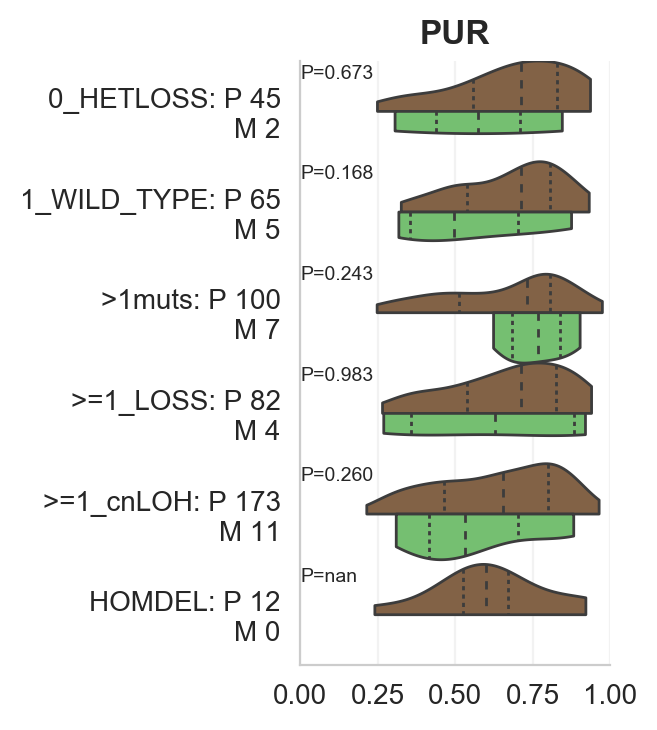

In [401]:
fig = plt.figure(figsize=(2,4))
ax = plt.subplot()


plot_mut_count_subgroups(master_cancer,
                         ax1=ax, 
                         cancer_type=cancer_type, 
                         metrics='purity',
                         title='PUR',  
                         xlim=1, 
                         met_prim = None,
                         continuous=True,
                         tp53_metrics=False,
                         linewidth=1,
                         width=1,
                         hue=True)
'''

plot_mut_count_subgroups(master_cancer, 
                         ax1=ax,
                         cancer_type=cancer_type, 
                         metrics='tp53_ccf', 
                         title= 'TP53_CCF ',  
                         xlim=1, 
                         met_prim = None,
                         tp53_metrics=True,
                         continuous=True,
                         linewidth=1,
                         hue=True)
'''

In [227]:
dic = {'a': 3, 'b':4, 'c':5}

In [229]:
list(dic.keys())

['a', 'b', 'c']

In [231]:
for i, value in enumerate(list(dic.values())):
    print(i, value)

0 3
1 4
2 5


In [268]:
from scipy.stats import fisher_exact, ranksums, chi2, norm
from statsmodels.sandbox.stats.multicomp import multipletests

statistic, p_value = ranksums(master_cancer[master_cancer['Sample_Type'] == 'Primary']['tp53_ccf_1'].dropna().values,master_cancer[master_cancer['Sample_Type'] == 'Metastasis']['tp53_ccf_1'].dropna().values)
if p_value<0.001:
    s='P < 0.001'
else:
    s='P = %.3f'%p_value

print(statistic, p_value)

1.2888083024285273 0.1974647389534665
